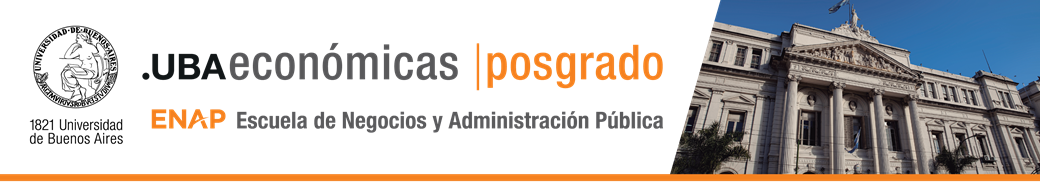

**Fundamentos de Métodos Analíticos Predictivos**

Trabajo final - individual

Paola  Viridiana Manzo Romero

**Se busca predecir el precio de las propiedades de departamento en CABA Argentina**

Para ejecutar el código es necesario:



1.   Archivo de entrenamiento y a predecir
2.   Ejecutar las librerias
3.   Ejecutar desde google colab o importar los archivo desde lo local que se encuentra en el zip documentado que son los mismos archivos de kaggle.

El material esta elaborado para importar y exportar todo desde la nube de google drive.


Se entrenaron con 3 algoritmos (los que soportó mi laptop): Linear Regressor, Random Forest Regressor y XGBoost Regressor



# **Lectura de datos y librerias**

In [ ]:
#Importar librerias
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn 
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer 

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.metrics import r2_score

from sklearn.feature_selection import SelectFromModel

Conexión con nube de drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importamos csv de entrenamiento y para predecir

In [ ]:
# leemos el archivo .csv 
# Datos de entrenamiento y para predecir
df_entrenamiento=pd.read_csv('/content/drive/MyDrive/Almacenamiento/Maestria/Segundo/FMAP/TP/propiedades_entrenamiento.csv')
df_predecir=pd.read_csv('/content/drive/MyDrive/Almacenamiento/Maestria/Segundo/FMAP/TP/propiedades_a_predecir.csv')

# **1. Exploración de datos de entrenamiento**


**Se carga el conjunto de entrenamiento y se trabaja con este dataset.**

Hay 100,000 observaciones y 25 columnas



In [ ]:
#Dimensión de la base
df_entrenamiento.shape

(100000, 25)

**Observamos el tipo de datos contenidos en cada columna**


In [ ]:
#Tipo de estructura de la variable
df_entrenamiento.dtypes

id                  object
ad_type             object
start_date          object
end_date            object
created_on          object
lat                float64
lon                float64
l1                  object
l2                  object
l3                  object
l4                  object
l5                 float64
l6                 float64
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price              float64
currency            object
price_period        object
title               object
description         object
property_type       object
operation_type      object
dtype: object

In [ ]:
#Todos los datos son propiedades
df_entrenamiento.groupby(['ad_type']).ad_type.agg('count')

ad_type
Propiedad    100000
Name: ad_type, dtype: int64

Variable fechas

In [ ]:
# Vemos el número de observaciones de la variable end_date
df_entrenamiento.groupby(['end_date']).end_date.agg('count')

end_date
2020-05-26        2
2020-05-27        2
2020-05-28        6
2020-05-29       34
2020-05-30        6
              ...  
2021-08-13       82
2021-08-14       31
2021-08-15       17
2021-08-16       11
9999-12-31    17739
Name: end_date, Length: 447, dtype: int64

In [ ]:
# Vemos el número de observaciones de la variable start_date
df_entrenamiento.groupby(['start_date']).start_date.agg('count')

start_date
2020-05-24    121
2020-05-25     77
2020-05-26    135
2020-05-27    257
2020-05-28    183
             ... 
2021-06-12    196
2021-06-13     80
2021-06-15    306
2021-06-16    313
2021-06-17    270
Name: start_date, Length: 362, dtype: int64

Variables l1:l6

La variable l5 y l6 estan varias, no hay información

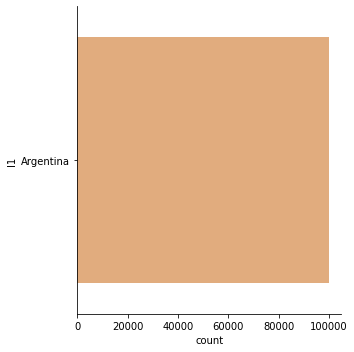

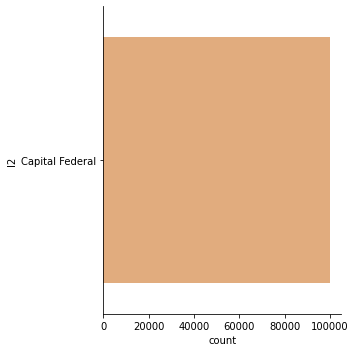

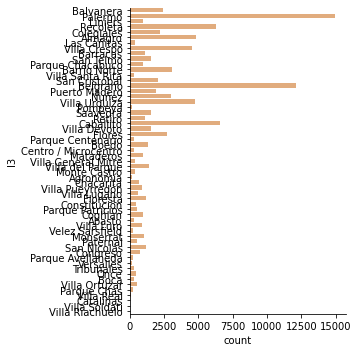

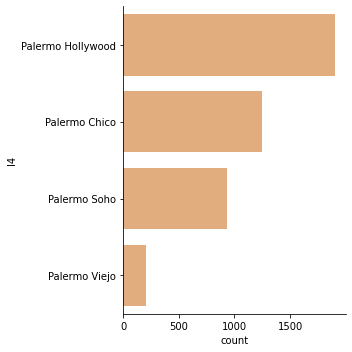

In [ ]:
sns.catplot(y = "l1", data = df_entrenamiento, kind = "count", color='#F2AB6D')
sns.catplot(y = "l2", data = df_entrenamiento, kind = "count", color='#F2AB6D')

sns.catplot(y = "l3", data = df_entrenamiento, kind = "count", color='#F2AB6D')
sns.catplot(y = "l4", data = df_entrenamiento, kind = "count", color='#F2AB6D')


Variables rooms, bed y bathrooms

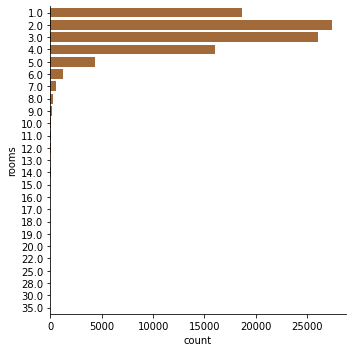

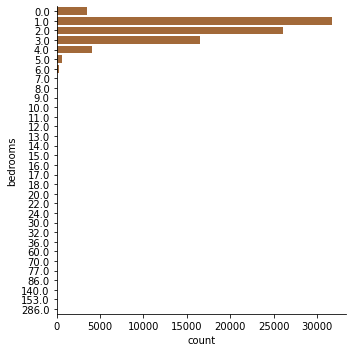

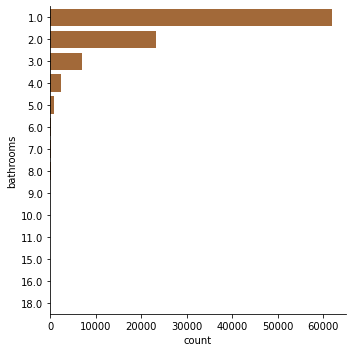

In [ ]:
sns.catplot(y = "rooms", data = df_entrenamiento, kind = "count", color='#b36827')
sns.catplot(y = "bedrooms", data = df_entrenamiento, kind = "count", color='#b36827')
sns.catplot(y = "bathrooms", data = df_entrenamiento, kind = "count", color='#b36827')


Variable surface_total y surface_covered 


Text(0, 0.5, 'Frecuencia')

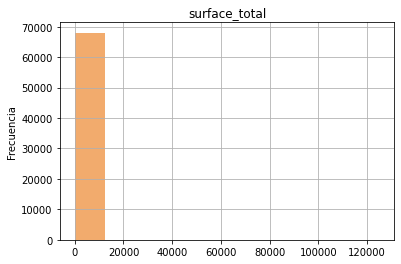

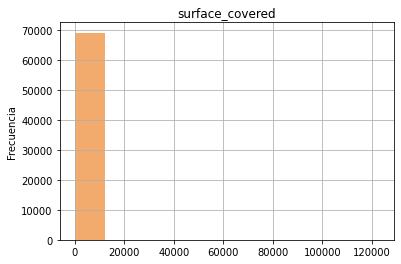

In [ ]:
df_entrenamiento.hist('surface_total', color='#F2AB6D')
plt.title('surface_total')
plt.ylabel('Frecuencia')

df_entrenamiento.hist('surface_covered', color='#F2AB6D')
plt.title('surface_covered')
plt.ylabel('Frecuencia')


Variable precio

Text(0, 0.5, 'price')

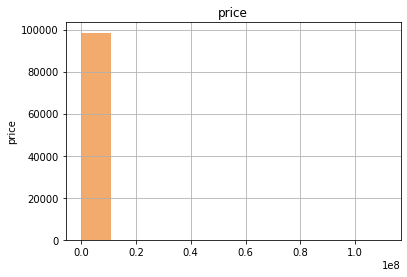

In [ ]:
#Variable price
df_entrenamiento.hist('price', color='#F2AB6D')
plt.xlabel('')
plt.ylabel('price')


In [ ]:
# Vemos el número de observaciones de la variable tipo de propiedad
df_entrenamiento.groupby(['currency']).currency.agg('count')

currency
ARS      109
USD    98289
Name: currency, dtype: int64

In [ ]:
# Vemos el número de observaciones de la variable tipo de propiedad
df_entrenamiento.groupby(['property_type']).property_type.agg('count')

property_type
Departamento    90037
Oficina           821
PH               9142
Name: property_type, dtype: int64

In [ ]:
# Vemos el número de observaciones de la variable operation_type venta
df_entrenamiento.groupby(['operation_type']).operation_type.agg('count')

operation_type
Venta    100000
Name: operation_type, dtype: int64

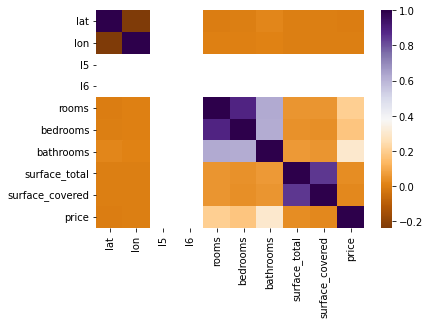

In [ ]:
#Matriz de correlaciones
df_corr_matrix=df_entrenamiento.corr()

sns.heatmap(df_corr_matrix, cmap='PuOr')

# **Limpieza de datos y manejo de NaN datos de entrenamiento**

Ya que *price* es la variable dependiente se retira los valores vacios y los valores sin relevancia como $11 el precio de una propiedad

In [ ]:
#dimensión de las propiedades con el primer filtro el precio
df=df_entrenamiento[df_entrenamiento['price']>11]
df.shape

(98396, 25)

Dado lo comentado en la clases en relación a la competencia de Kaggle, se determinó que el pronóstico de las propiedades deben corresponder los datos a:
* Propiedades que sean **departamento**
* Se encuentre dentro de **CABA**

**Señalamos unicamente las propiedades de Departamento y PH y que se ubique en CABA**

In [ ]:
#Se extrae las propiedades que sean diferente a "Oficina", es decir, "departamento" y "PH"
df=df[df['property_type']!="Oficina"]
df.shape

(97605, 25)

In [ ]:
import numpy as np
df["ID"]=np.arange(len(df))

**Valores** **perdidos**

In [ ]:
# Valores perdidos con las primeras manipulaciones al data frame de entrenamiento
df.isnull().sum()

id                     0
ad_type                0
start_date             0
end_date               0
created_on             0
lat                 5924
lon                 5924
l1                     0
l2                     0
l3                   381
l4                 93479
l5                 97605
l6                 97605
rooms               4718
bedrooms           16051
bathrooms           4506
surface_total      31534
surface_covered    30622
price                  0
currency               0
price_period       52079
title                  0
description            0
property_type          0
operation_type         0
ID                     0
dtype: int64

**Imputar con KNN**

In [ ]:
df['ID'] = df['ID'].astype('float64')
df['lat'] = df['lat'].astype('float64')
df['lon'] = df['lon'].astype('float64')
df['bedrooms'] = df['bedrooms'].astype('float64')
df['bathrooms'] = df['bathrooms'].astype('float64')
df['rooms'] = df['rooms'].astype('float64')
df['surface_total'] = df['surface_total'].astype('float64')
df['surface_covered'] = df['surface_covered'].astype('float64')

In [ ]:
df.columns[25]

'ID'

In [ ]:
df_knn=df.iloc[:,[5,6,13,14,15,16,17,18, 25]]
df_knn.columns

Index(['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'ID'],
      dtype='object')

In [ ]:
imp=KNNImputer(n_neighbors=5, weights='distance')  
temp=imp.fit_transform(df_knn)
temp=pd.DataFrame(temp, columns=['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'ID'])

In [ ]:
temp.isnull().sum()

lat                0
lon                0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
ID                 0
dtype: int64

In [ ]:
df.columns[25]

'ID'

In [ ]:
df_p2=df.iloc[:,[0,1,2,3,4,7,8,9,10,11,12,19,20,21,22,23,24,25]]

In [ ]:
result = pd.merge(df_p2, temp, on=["ID", "ID"])


In [ ]:
result.isnull().sum()

id                     0
ad_type                0
start_date             0
end_date               0
created_on             0
l1                     0
l2                     0
l3                   381
l4                 93479
l5                 97605
l6                 97605
currency               0
price_period       52079
title                  0
description            0
property_type          0
operation_type         0
ID                     0
lat                    0
lon                    0
rooms                  0
bedrooms               0
bathrooms              0
surface_total          0
surface_covered        0
price                  0
dtype: int64

In [ ]:
df=result

Variable end_date
* Hay una fecha extraña 9999-12-31
* Se buscaba hacer una variable que cuente los días de publicación de las propiedades pero se observa que en datos a predecir la fecha es una constante :(

In [ ]:
df["end_date"][df.end_date.str.contains('9999-12-31',na=False)].count()

17408

l3 barrios

Que se observa en la variable l3 que refiere a los barrios

* Hay 381 datos perdidos, estos se eliminaran.
* Hay barrios que no estan clasificados correctamente se renombraran


In [ ]:
#Valores perdidos de la variable "L3"
df["l3"].isnull().sum()

381

In [ ]:
df=df.dropna(subset = ["l3"], axis = 0)

In [ ]:
df.l3.unique()

array(['Balvanera', 'Palermo', 'Liniers', 'Recoleta', 'Colegiales',
       'Almagro', 'Las Cañitas', 'Villa Crespo', 'Barracas', 'San Telmo',
       'Parque Chacabuco', 'Barrio Norte', 'Villa Santa Rita',
       'San Cristobal', 'Belgrano', 'Puerto Madero', 'Nuñez',
       'Villa Urquiza', 'Pompeya', 'Saavedra', 'Retiro', 'Caballito',
       'Villa Devoto', 'Flores', 'Parque Centenario', 'Boedo',
       'Centro / Microcentro', 'Mataderos', 'Villa General Mitre',
       'Villa del Parque', 'Monte Castro', 'Agronomía', 'Chacarita',
       'Villa Pueyrredón', 'Villa Lugano', 'Floresta', 'Constitución',
       'Parque Patricios', 'Coghlan', 'Abasto', 'Villa Luro',
       'Velez Sarsfield', 'Monserrat', 'Paternal', 'San Nicolás',
       'Congreso', 'Parque Avellaneda', 'Versalles', 'Tribunales', 'Once',
       'Boca', 'Villa Ortuzar', 'Parque Chas', 'Villa Real', 'Catalinas',
       'Villa Soldati', 'Villa Riachuelo'], dtype=object)

In [ ]:
#Renombrar barrios
df.replace('Parque Centenario', 'Caballito', inplace=True)
df.replace('Once', 'Balvanera', inplace=True)
df.replace('Catalinas', 'Boca', inplace=True)
df.replace('Las Cañitas', 'Palermo', inplace=True)
df.replace('Congreso', 'Balvanera', inplace=True)
df.replace('Tribunales', 'San Nicolas', inplace=True)
df.replace('Centro / Microcentro', 'San Nicolas', inplace=True)
df.replace('Abasto', 'Almagro', inplace=True)
df.replace('Barrio Norte', 'Recoleta', inplace=True)
df.replace('Villa General Mitre', 'Villa Gral. Mitre', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
df = df.rename(columns = {"l3":"barrio"})

Manejo de NaN en variables: rooms, bedrooms y bathrooms

* Sí hay valores NaN se les asigna el valor de 1, suponiendo que la propiedad tenga al menos 1 baño, 1 habitación.

In [ ]:
#Remplazamos los valores atipicos
df['bedrooms'] = df['bedrooms'].replace({ 0: 1, 13:12, 14:12, 15:12, 16:12,
                                                  17:12, 18:12, 20:12, 22:12, 24:12,
                                                  30:12, 32:12, 36:12, 60:12, 70:12,
                                                  77:12, 86:12,140:12, 153:12,286:12})
df[['bedrooms']] = df[['bedrooms']].fillna(1)
df['bedrooms'].unique()



array([2.        , 1.        , 3.        , ..., 2.99619944, 2.72886934,
       0.84228694])

In [ ]:
#Remplazamos los valores atipicos 
df['rooms'] = df['rooms'].replace({0: 1,10:9, 11:9,12:9, 13:9, 14:9, 15:9, 16:9, 17:9, 18:9, 19:9, 20:9, 22:9, 25:9,28:9, 30:9, 35:9 })
df[['rooms']] = df[['rooms']].fillna(1)
df['rooms'].unique()

array([3.        , 1.        , 2.        , ..., 4.15133569, 2.2459424 ,
       3.33186193])

In [ ]:
#Remplazamos outlier
df['bathrooms'] = df['bathrooms'].replace({10:9, 11:9, 15:9, 16:9, 18:9})
df[['bathrooms']] = df[['bathrooms']].fillna(1)
df['bathrooms'].unique()

array([1.        , 2.        , 1.37858252, ..., 2.59830079, 1.99305689,
       2.51846153])

In [ ]:
df.shape

(97224, 26)

In [ ]:
df.isnull().sum()

id                     0
ad_type                0
start_date             0
end_date               0
created_on             0
l1                     0
l2                     0
barrio                 0
l4                 93098
l5                 97224
l6                 97224
currency               0
price_period       51932
title                  0
description            0
property_type          0
operation_type         0
ID                     0
lat                    0
lon                    0
rooms                  0
bedrooms               0
bathrooms              0
surface_total          0
surface_covered        0
price                  0
dtype: int64

Métricas

El archivo métricas incluye información de acuerdo a barrios de CABA, esta información se recabo de sitios públicos y el código se anexa [aquí](https://colab.research.google.com/drive/1iIF5ocsF7lHroLaAJFBT7b1YODsFiptg?usp=sharing)

In [ ]:
#Cargamos csv que yo realice en donde se recabo diversa inf
metricas_barrio=pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQK6hlS8ZVOr4tE3tq_99igHZcq4AAdRC1MmtzT_VEJcTBAciCfs9u2uXuAUI5FsFyQevCn6PBjSqwy/pub?output=csv")

In [ ]:
metricas_barrio.head(2)

,barrio,comuna,sector,población,m2_promedio,areas_verdes,robo con violencia,hurto,areas_verdes_percapita,robo_violencia_año_10hab,hurto_año_10hab
0,Agronomia,Comuna 15,Centro,13912,1643,2833.542,130,126,0.20,934,906
1,Almagro,Comuna 5,Centro,131699,1706,10076.375,1996,1358,0.08,1516,1031


In [ ]:
df = df.merge(metricas_barrio, on='barrio')

In [ ]:
df['barrio2']=df['barrio'].astype('category').cat.codes

In [ ]:
df.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'l1', 'l2',
       'barrio', 'l4', 'l5', 'l6', 'currency', 'price_period', 'title',
       'description', 'property_type', 'operation_type', 'ID', 'lat', 'lon',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'comuna', 'sector', 'población', 'm2_promedio', 'areas_verdes',
       'robo con violencia', 'hurto', 'areas_verdes_percapita',
       'robo_violencia_año_10hab', 'hurto_año_10hab', 'barrio2'],
      dtype='object')

# **Creación de variables datos de entrenamiento**

Variable property_type a dummy

In [ ]:
df_property=pd.get_dummies(df, columns=["property_type"])
df_property.shape

(93071, 38)

In [ ]:
df_property.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'l1', 'l2',
       'barrio', 'l4', 'l5', 'l6', 'currency', 'price_period', 'title',
       'description', 'operation_type', 'ID', 'lat', 'lon', 'rooms',
       'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price',
       'comuna', 'sector', 'población', 'm2_promedio', 'areas_verdes',
       'robo con violencia', 'hurto', 'areas_verdes_percapita',
       'robo_violencia_año_10hab', 'hurto_año_10hab', 'barrio2',
       'property_type_Departamento', 'property_type_PH'],
      dtype='object')

Variable currency

In [ ]:
df_currency=pd.get_dummies(df_property, columns=["currency"])
df_currency.shape

(93071, 39)

In [ ]:
df = df_currency
df.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'l1', 'l2',
       'barrio', 'l4', 'l5', 'l6', 'price_period', 'title', 'description',
       'operation_type', 'ID', 'lat', 'lon', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'comuna', 'sector',
       'población', 'm2_promedio', 'areas_verdes', 'robo con violencia',
       'hurto', 'areas_verdes_percapita', 'robo_violencia_año_10hab',
       'hurto_año_10hab', 'barrio2', 'property_type_Departamento',
       'property_type_PH', 'currency_ARS', 'currency_USD'],
      dtype='object')

Precio por metro cuadrado

In [ ]:
#Precio logaritmo
df["lprice"] = np.log(df['price'])

In [ ]:
df["price2"] = df['surface_total'] * df['m2_promedio']

In [ ]:
df["price"].round(0)

0        110000.0
1         89500.0
2         99000.0
3         64000.0
4        152000.0
           ...   
93066    120000.0
93067    109000.0
93068     85000.0
93069     65000.0
93070    125000.0
Name: price, Length: 93071, dtype: float64

In [ ]:
df["bañ/hab"] = df['bathrooms'] * df['rooms']

In [ ]:
df.shape

(93071, 42)

Variable

**Variable de texto**

In [ ]:
#Pasar a minusculas
df["description"]=df["description"].str.lower()
df["description"][1]

'departamento 2 ambientes en muy buena ubicacion (1 cuadra av cordoba  3 cuadras av pueyrredon y subte). el departamento es muy luminoso  tiene pisos de parquet y un aire acondicionado split frio/calor en el living  living comedor con balcon frances  cocina independiente con desayunador  lavadero independiente  baño completo  placard en el pasillo y dormitorio con placard. las medidas  superficies y montos de expensas consignadas en la presente descripción son aproximadas  a solo título orientativo y no son vinculantes. las medidas y superficies reales surgen del título respectivo  y el monto de expensas real  del recibo emitido por la administración del consorcio de copropietarios que rige el inmueble.\xa0  xintel(lui-lui-10439)'

In [ ]:
#se crea uan función que quita tilde y pasa texto a minúscula
def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [ ]:
df.description.map(normalize)

0        venta de departamento 3 ambientes en balvanera...
1        departamento 2 ambientes en muy buena ubicacio...
2        sobre la calle sarmiento al 2300 esquina azcue...
3        departamento 2 ambientes en muy buena ubicacio...
4        apto credito. apto profesional. apto mascotas....
                               ...                        
93066    divino ph amplio en buen estado luminoso con p...
93067    apto profesional. apto comercial. ph tipo casa...
93068    impecable estado  solo 6 años de antiguedad  i...
93069    corredor responsable: monica alejandra mazza -...
93070    corredor responsable: oscar n. liberman - cuci...
Name: description, Length: 93071, dtype: object

Crear variable que se llame balcón y que tenga en la descripción de la propiedad balcón

In [ ]:
#ahora buscamos si existe la palabra "balcón" en la variable descripcion y contamos
df["description"][df.description.str.contains('balcón',na=False)].count()

40717

In [ ]:
df.description.str.contains('balcón',na=False)

0         True
1        False
2        False
3        False
4         True
         ...  
93066    False
93067    False
93068    False
93069     True
93070    False
Name: description, Length: 93071, dtype: bool

In [ ]:
#creamos una nueva variable que diga True o False en base a sentencia anterior 
df["balcon"]=df.description.str.contains('balcón',na=False)

In [ ]:
df["balcon"]=df.description.str.contains('balcón',na=False)

In [ ]:
#recodificamos
df['balcon']=[1 if i==True else 0 for i in df['balcon']]


In [ ]:
# verificamos la cantidad que quedaron con 1 
df['balcon'].value_counts()

0    52354
1    40717
Name: balcon, dtype: int64

Variable dummy para aquellas propiedades que en la descripción mencionen tener aire acondicionado

In [ ]:
df["description"][df.description.str.contains('aire acondicionado',na=False)].count()

18793

In [ ]:
df["aire_aco"]=df.description.str.contains('aire acondicionado',na=False)

In [ ]:
#recodificamos
df['aire_aco']=[1 if i==True else 0 for i in df['aire_aco']]

In [ ]:
# verificamos la cantidad que quedaron con 1
df['aire_aco'].value_counts()

0    74278
1    18793
Name: aire_aco, dtype: int64

Variable dummy para subte de la descripción de las variables

In [ ]:
df["description"][df.description.str.contains('subte',na=False)].count()

27107

In [ ]:
df["subte_d"]=df.description.str.contains('subte',na=False)

In [ ]:
#recodificamos
df['subte_d']=[1 if i==True else 0 for i in df['subte_d']]

In [ ]:
# verificamos la cantidad que quedaron con 1
df['subte_d'].value_counts()

0    65964
1    27107
Name: subte_d, dtype: int64

Creamos variable terraza dummy que incluye en la descripcition

In [ ]:
df["description"][df.description.str.contains('terraza',na=False)].count()

27531

In [ ]:
df["terraza"]=df.description.str.contains('terraza',na=False)

In [ ]:
#recodificamos
df['terraza']=[1 if i==True else 0 for i in df['terraza']]

In [ ]:
# verificamos la cantidad que quedaron con 1
df['terraza'].value_counts()

0    65540
1    27531
Name: terraza, dtype: int64

In [ ]:
df.shape

(93071, 46)

creamos una variable dummy para lo que mencionan tener cochera

In [ ]:
#ahora buscamos si existe la palabra "cochera" en la variable descripcion y contamos
df["description"][df.description.str.contains('cochera',na=False)].count()

33786

In [ ]:
df.description.str.contains('cochera',na=False)

0        False
1        False
2        False
3        False
4        False
         ...  
93066    False
93067     True
93068    False
93069    False
93070    False
Name: description, Length: 93071, dtype: bool

In [ ]:
#creamos una nueva variable que diga True o False en base a sentencia anterior 
df["cochera"]=df.description.str.contains('cochera',na=False)

In [ ]:
df["cochera"]=df.description.str.contains('cochera',na=False)

In [ ]:
#recodificamos
df['cochera']=[1 if i==True else 0 for i in df['cochera']]


In [ ]:
# verificamos la cantidad que quedaron con 1
df['cochera'].value_counts()

0    59285
1    33786
Name: cochera, dtype: int64

creamos una variable dummy para lo que mencionan tener piscina

In [ ]:
#ahora buscamos si existe la palabra "piscina" en la variable descripcion y contamos
df["description"][df.description.str.contains('piscina',na=False)].count()

12822

In [ ]:
df.description.str.contains('piscina',na=False)

0        False
1        False
2        False
3        False
4        False
         ...  
93066    False
93067    False
93068    False
93069    False
93070    False
Name: description, Length: 93071, dtype: bool

In [ ]:
#creamos una nueva variable que diga True o False en base a sentencia anterior 
df["piscina"]=df.description.str.contains('piscina',na=False)

In [ ]:
df["piscina"]=df.description.str.contains('piscina',na=False)

In [ ]:
#recodificamos
df['piscina']=[1 if i==True else 0 for i in df['piscina']]


In [ ]:
# verificamos la cantidad que quedaron con 1
df['piscina'].value_counts()

0    80249
1    12822
Name: piscina, dtype: int64

Variable dummy de las propiedades donde menciona que menciona que tiene lavadero en la descripción

In [ ]:
#ahora buscamos si existe la palabra "lavadero" en la variable descripcion y contamos
df["description"][df.description.str.contains('lavadero',na=False)].count()

35182

In [ ]:
df.description.str.contains('lavadero',na=False)

0        False
1         True
2         True
3         True
4         True
         ...  
93066     True
93067    False
93068    False
93069     True
93070     True
Name: description, Length: 93071, dtype: bool

In [ ]:
#creamos una nueva variable que diga True o False en base a sentencia anterior 
df["lavadero"]=df.description.str.contains('lavadero',na=False)

In [ ]:
df["lavadero"]=df.description.str.contains('lavadero',na=False)

In [ ]:
#recodificamos
df['lavadero']=[1 if i==True else 0 for i in df['lavadero']]


In [ ]:
# verificamos la cantidad que quedaron con 1
df['lavadero'].value_counts()

0    57889
1    35182
Name: lavadero, dtype: int64

Variable dummy de las propiedades donde menciona que menciona que tiene un parque cercano en la descripción

In [ ]:
#ahora buscamos si existe la palabra "parque" en la variable descripcion y contamos
df["description"][df.description.str.contains('parque',na=False)].count()

21557

In [ ]:
df.description.str.contains('parque',na=False)

0         True
1         True
2        False
3         True
4        False
         ...  
93066    False
93067    False
93068     True
93069    False
93070    False
Name: description, Length: 93071, dtype: bool

In [ ]:
#creamos una nueva variable que diga True o False en base a sentencia anterior 
df["parque"]=df.description.str.contains('parque',na=False)

In [ ]:
df["parque"]=df.description.str.contains('parque',na=False)

In [ ]:
#recodificamos
df['parque']=[1 if i==True else 0 for i in df['parque']]


In [ ]:
# verificamos la cantidad que quedaron con 1
df['parque'].value_counts()

0    71514
1    21557
Name: parque, dtype: int64

Variable dummy de las propiedades donde menciona que menciona que tiene seguridad en la descripción

In [ ]:
#ahora buscamos si existe la palabra "seguridad" en la variable descripcion y contamos
df["description"][df.description.str.contains('seguridad',na=False)].count()

14870

In [ ]:
df.description.str.contains('seguridad',na=False)

0        False
1        False
2        False
3        False
4         True
         ...  
93066    False
93067    False
93068    False
93069    False
93070    False
Name: description, Length: 93071, dtype: bool

In [ ]:
#creamos una nueva variable que diga True o False en base a sentencia anterior 
df["seguridad"]=df.description.str.contains('seguridad',na=False)

In [ ]:
df["seguridad"]=df.description.str.contains('seguridad',na=False)

In [ ]:
#recodificamos
df['seguridad']=[1 if i==True else 0 for i in df['seguridad']]

In [ ]:
# verificamos la cantidad que quedaron con 1 
df['seguridad'].value_counts()

0    78201
1    14870
Name: seguridad, dtype: int64

Variable dummy de las propiedades donde menciona quue es nuevo

In [ ]:
#ahora buscamos si existe la palabra "parque" en la variable descripcion y contamos
df["description"][df.description.str.contains('a estrenar',na=False)].count()

7772

In [ ]:
df.description.str.contains('a estrenar',na=False)

0        False
1        False
2        False
3        False
4        False
         ...  
93066    False
93067    False
93068    False
93069    False
93070    False
Name: description, Length: 93071, dtype: bool

In [ ]:
#creamos una nueva variable que diga True o False en base a sentencia anterior 
df["estrenar"]=df.description.str.contains('a estrenar',na=False)

In [ ]:
df["estrenar"]=df.description.str.contains('a estrenar',na=False)

In [ ]:
#recodificamos
df['estrenar']=[1 if i==True else 0 for i in df['estrenar']]

In [ ]:
# verificamos la cantidad que quedaron con 1 
df['estrenar'].value_counts()

0    85299
1     7772
Name: estrenar, dtype: int64

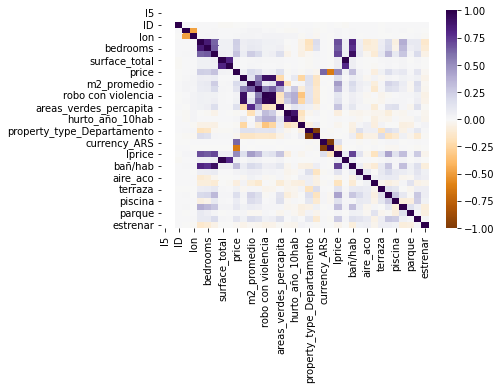

In [ ]:
#Heatmap de las variables limpias
corr_matrix=df.corr()
 
# plot it
sns.heatmap(corr_matrix, cmap='PuOr')

# **Datos externos**

## Estaciones de subte

In [ ]:
!wget https://cdn.buenosaires.gob.ar/datosabiertos/datasets/sbase/subte-estaciones/estaciones-de-subte.csv

--2022-09-22 20:49:48--  https://cdn.buenosaires.gob.ar/datosabiertos/datasets/sbase/subte-estaciones/estaciones-de-subte.csv
Resolving cdn.buenosaires.gob.ar (cdn.buenosaires.gob.ar)... 200.16.89.97
Connecting to cdn.buenosaires.gob.ar (cdn.buenosaires.gob.ar)|200.16.89.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5238 (5.1K) [text/csv]
Saving to: ‘estaciones-de-subte.csv’

estaciones-de-subte 100%[===================>]   5.12K  --.-KB/s    in 0s      

2022-09-22 20:49:49 (80.8 MB/s) - ‘estaciones-de-subte.csv’ saved [5238/5238]



In [ ]:
subte=pd.read_csv("/content/estaciones-de-subte.csv")

In [ ]:
subte

,long,lat,id,estacion,linea
0,-58.398928,-34.635750,1.0,CASEROS,H
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H
3,-58.404732,-34.615242,4.0,VENEZUELA,H
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H
...,...,...,...,...,...
85,-58.402376,-34.594525,86.0,SANTA FE - CARLOS JAUREGUI,H
86,-58.391019,-34.583036,87.0,FACULTAD DE DERECHO - JULIETA LANTERI,H
87,-58.375850,-34.592114,90.0,RETIRO,E
88,-58.371700,-34.596597,89.0,CATALINAS,E


La fórmula para calcular distancia lineal:
Distancia en línea recta = 6371 * ACOS( COS((Lat1 * 3,141592654)/180) * COS((Lat2 * 3,141592654)/180) * COS((Long2 * 3,141592654)/180) - (Long1 * 3,141592654)/180)) + SIN((Lat1 * 3,141592654)/180) * SIN(Lat2 * 3,141592654)/180))

Donde:
Lat 1, es el campo Latitud de cada estación,
Long 1 , es el campo Longitud de cada estación
Lat 2, es el campo Latitud del conjunto de datos
Long 2, es el campo Longitud del conjunto de datos


NOTA: la multiplicación por PI y dividir por 180 es para convertir una lat (o long) a distancia en mts

In [ ]:
import math
math.pi

3.141592653589793

In [ ]:
from numpy import cos, sin
import math
#en el conjunto de datos de las estaciones, calculamos cos((Lat1 * 3,141592654)/180)) y cos((Long1 * 3,141592654)/180)) y también el seno

subte['long_1']= (subte['long']*math.pi)/180

subte['LAT1_cos']= cos((subte['lat']*math.pi)/180)

subte['LONG1_cos']=cos((subte['long']*math.pi)/180)

subte['LAT1_sen']= sin((subte['lat']*math.pi)/180)

subte['LONG1_sen']=sin((subte['long']*math.pi)/180)

In [ ]:
subte

,long,lat,id,estacion,linea,long_1,LAT1_cos,LONG1_cos,LAT1_sen,LONG1_sen
0,-58.398928,-34.635750,1.0,CASEROS,H,-1.019254,0.822782,0.524002,-0.568357,-0.851717
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,-1.019289,0.822845,0.523971,-0.568266,-0.851736
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,-1.019313,0.822907,0.523951,-0.568175,-0.851748
3,-58.404732,-34.615242,4.0,VENEZUELA,H,-1.019355,0.822985,0.523916,-0.568063,-0.851770
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,-1.019378,0.823048,0.523896,-0.567972,-0.851782
...,...,...,...,...,...,...,...,...,...,...
85,-58.402376,-34.594525,86.0,SANTA FE - CARLOS JAUREGUI,H,-1.019314,0.823191,0.523951,-0.567765,-0.851749
86,-58.391019,-34.583036,87.0,FACULTAD DE DERECHO - JULIETA LANTERI,H,-1.019116,0.823304,0.524119,-0.567600,-0.851645
87,-58.375850,-34.592114,90.0,RETIRO,E,-1.018851,0.823215,0.524345,-0.567730,-0.851506
88,-58.371700,-34.596597,89.0,CATALINAS,E,-1.018778,0.823170,0.524407,-0.567795,-0.851468


In [ ]:
#Lo calculamos en e df de propiedades de entrenamiento
df['longitud_1']=(df['lat']*math.pi)/180

df['LATITUD_cos']= cos((df['lat']*math.pi)/180)

df['LONGITUD_cos']=cos((df['lon']*math.pi)/180)

df['LATITUD_sen']= sin((df['lat']*math.pi)/180)

df['LONGITUD_sen']=sin((df['lon']*math.pi)/180)

In [ ]:
#Extraemos del dataset de subte solo nos quedamos con las variables recién calculadas

subte= subte.iloc[:,[5,6,7,8,9]]

In [ ]:
subte

,long_1,LAT1_cos,LONG1_cos,LAT1_sen,LONG1_sen
0,-1.019254,0.822782,0.524002,-0.568357,-0.851717
1,-1.019289,0.822845,0.523971,-0.568266,-0.851736
2,-1.019313,0.822907,0.523951,-0.568175,-0.851748
3,-1.019355,0.822985,0.523916,-0.568063,-0.851770
4,-1.019378,0.823048,0.523896,-0.567972,-0.851782
...,...,...,...,...,...
85,-1.019314,0.823191,0.523951,-0.567765,-0.851749
86,-1.019116,0.823304,0.524119,-0.567600,-0.851645
87,-1.018851,0.823215,0.524345,-0.567730,-0.851506
88,-1.018778,0.823170,0.524407,-0.567795,-0.851468


In [ ]:
len(subte)

90

In [ ]:
#por cada registro del conjunto de datos (cada propiedad), se debe calcular la distancia a cada estación
#para eso, al conjunto de datos estaciones_1, le agregamos las 4 columnas traspuestas de las latitud y longitud recalculadas previamente.
#Cada una de estas columnas debe repetir el valor 90 veces, siendo el largo del conjunto estaciones_1

df.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'l1', 'l2',
       'barrio', 'l4', 'l5', 'l6', 'price_period', 'title', 'description',
       'operation_type', 'ID', 'lat', 'lon', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'comuna', 'sector',
       'población', 'm2_promedio', 'areas_verdes', 'robo con violencia',
       'hurto', 'areas_verdes_percapita', 'robo_violencia_año_10hab',
       'hurto_año_10hab', 'barrio2', 'property_type_Departamento',
       'property_type_PH', 'currency_ARS', 'currency_USD', 'lprice', 'price2',
       'bañ/hab', 'balcon', 'aire_aco', 'subte_d', 'terraza', 'cochera',
       'piscina', 'lavadero', 'parque', 'seguridad', 'estrenar', 'longitud_1',
       'LATITUD_cos', 'LONGITUD_cos', 'LATITUD_sen', 'LONGITUD_sen'],
      dtype='object')

In [ ]:
df.shape

(93071, 57)

In [ ]:
df.columns[56]

'LONGITUD_sen'

In [ ]:
#Columnas que calculamos en data
prop_temp= pd.DataFrame(df.iloc[:,[52,53,54,55,56]])
prop_temp

,longitud_1,LATITUD_cos,LONGITUD_cos,LATITUD_sen,LONGITUD_sen
0,-0.604007,0.823066,0.523916,-0.567945,-0.851770
1,-0.603884,0.823136,0.523875,-0.567844,-0.851795
2,-0.603989,0.823077,0.523979,-0.567930,-0.851731
3,-0.604010,0.823065,0.524002,-0.567948,-0.851717
4,-0.604115,0.823005,0.524109,-0.568034,-0.851651
...,...,...,...,...,...
93066,-0.605508,0.822213,0.522909,-0.569180,-0.852388
93067,-0.605463,0.822239,0.522948,-0.569143,-0.852365
93068,-0.605470,0.822234,0.523005,-0.569149,-0.852329
93069,-0.605612,0.822154,0.522945,-0.569265,-0.852366


In [ ]:
#le pegamos cada columna de estaciones_1, traspuesta (una columna por cada estación), repitiendo el valor 10 mil veces que es el largo de prop_temp
import pandas as pd
LAT1_cos=pd.DataFrame.transpose(pd.DataFrame(subte['LAT1_cos']))

In [ ]:
LAT1_cos.columns=['H1.0LAT1_cos','H2.0LAT1_cos','H3.0LAT1_cos','H4.0LAT1_cos','H5.0LAT1_cos','D6.0LAT1_cos','D7.0LAT1_cos','D8.0LAT1_cos',
                  'D9.0LAT1_cos','D10.0LAT1_cos','D11.0LAT1_cos','D12.0LAT1_cos','C13.0LAT1_cos','C14.0LAT1_cos','C15.0LAT1_cos','C16.0LAT1_cos',
                  'C17.0LAT1_cos','C18.0LAT1_cos','C19.0LAT1_cos','B20.0LAT1_cos','B21.0LAT1_cos','B22.0LAT1_cos','B23.0LAT1_cos','B24.0LAT1_cos',
                  'B25.0LAT1_cos','B26.0LAT1_cos','B27.0LAT1_cos','B28.0LAT1_cos','B29.0LAT1_cos','B30.0LAT1_cos','A31.0LAT1_cos','A32.0LAT1_cos',
                  'A33.0LAT1_cos','A34.0LAT1_cos','A35.0LAT1_cos','A36.0LAT1_cos','A37.0LAT1_cos','A38.0LAT1_cos','A39.0LAT1_cos','A40.0LAT1_cos',
                  'A41.0LAT1_cos','A42.0LAT1_cos','A43.0LAT1_cos','E44.0LAT1_cos','E45.0LAT1_cos','E46.0LAT1_cos','E47.0LAT1_cos','E48.0LAT1_cos',
                  'E49.0LAT1_cos','E50.0LAT1_cos','E51.0LAT1_cos','E52.0LAT1_cos','E53.0LAT1_cos','D54.0LAT1_cos','D55.0LAT1_cos','D56.0LAT1_cos',
                  'C57.0LAT1_cos','C58.0LAT1_cos','E59.0LAT1_cos','E60.0LAT1_cos','E61.0LAT1_cos','D62.0LAT1_cos','D63.0LAT1_cos','D64.0LAT1_cos',
                  'D65.0LAT1_cos','B66.0LAT1_cos','E67.0LAT1_cos','E68.0LAT1_cos','D69.0LAT1_cos','A70.0LAT1_cos','D71.0LAT1_cos','B72.0LAT1_cos',
                  'B73.0LAT1_cos','B74.0LAT1_cos','A75.0LAT1_cos','A76.0LAT1_cos','H77.0LAT1_cos','H78.0LAT1_cos','H79.0LAT1_cos','B80.0LAT1_cos',
                  'B81.0LAT1_cos','A83.0LAT1_cos','A82.0LAT1_cos','H84.0LAT1_cos','H85.0LAT1_cos','H86.0LAT1_cos','H87.0LAT1_cos','E90.0LAT1_cos',
                  'E89.0LAT1_cos','E88.0LAT1_cos']

In [ ]:
LAT1_cos

,H1.0LAT1_cos,H2.0LAT1_cos,H3.0LAT1_cos,H4.0LAT1_cos,H5.0LAT1_cos,D6.0LAT1_cos,D7.0LAT1_cos,D8.0LAT1_cos,D9.0LAT1_cos,D10.0LAT1_cos,...,B81.0LAT1_cos,A83.0LAT1_cos,A82.0LAT1_cos,H84.0LAT1_cos,H85.0LAT1_cos,H86.0LAT1_cos,H87.0LAT1_cos,E90.0LAT1_cos,E89.0LAT1_cos,E88.0LAT1_cos
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106


In [ ]:
LAT1_cos=pd.DataFrame(LAT1_cos.loc[np.repeat(LAT1_cos.index.values, 10000)])

In [ ]:
LAT1_cos

,H1.0LAT1_cos,H2.0LAT1_cos,H3.0LAT1_cos,H4.0LAT1_cos,H5.0LAT1_cos,D6.0LAT1_cos,D7.0LAT1_cos,D8.0LAT1_cos,D9.0LAT1_cos,D10.0LAT1_cos,...,B81.0LAT1_cos,A83.0LAT1_cos,A82.0LAT1_cos,H84.0LAT1_cos,H85.0LAT1_cos,H86.0LAT1_cos,H87.0LAT1_cos,E90.0LAT1_cos,E89.0LAT1_cos,E88.0LAT1_cos
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106


In [ ]:
LAT1_cos=LAT1_cos.reset_index(drop=True)

In [ ]:
cos_test=pd.concat([prop_temp, LAT1_cos], axis=1)

In [ ]:
cos_test

,longitud_1,LATITUD_cos,LONGITUD_cos,LATITUD_sen,LONGITUD_sen,H1.0LAT1_cos,H2.0LAT1_cos,H3.0LAT1_cos,H4.0LAT1_cos,H5.0LAT1_cos,...,B81.0LAT1_cos,A83.0LAT1_cos,A82.0LAT1_cos,H84.0LAT1_cos,H85.0LAT1_cos,H86.0LAT1_cos,H87.0LAT1_cos,E90.0LAT1_cos,E89.0LAT1_cos,E88.0LAT1_cos
0,-0.604007,0.823066,0.523916,-0.567945,-0.851770,0.822782,0.822845,0.822907,0.822985,0.823048,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
1,-0.603884,0.823136,0.523875,-0.567844,-0.851795,0.822782,0.822845,0.822907,0.822985,0.823048,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
2,-0.603989,0.823077,0.523979,-0.567930,-0.851731,0.822782,0.822845,0.822907,0.822985,0.823048,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
3,-0.604010,0.823065,0.524002,-0.567948,-0.851717,0.822782,0.822845,0.822907,0.822985,0.823048,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
4,-0.604115,0.823005,0.524109,-0.568034,-0.851651,0.822782,0.822845,0.822907,0.822985,0.823048,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93066,-0.605508,0.822213,0.522909,-0.569180,-0.852388,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93067,-0.605463,0.822239,0.522948,-0.569143,-0.852365,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93068,-0.605470,0.822234,0.523005,-0.569149,-0.852329,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93069,-0.605612,0.822154,0.522945,-0.569265,-0.852366,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
subte.columns

Index(['long_1', 'LAT1_cos', 'LONG1_cos', 'LAT1_sen', 'LONG1_sen'], dtype='object')

In [ ]:
#seguimos con las otras
LONG1_cos=pd.DataFrame.transpose(pd.DataFrame(subte['LONG1_cos']))
LONG1_cos.columns=['H1.0LONG1_cos','H2.0LONG1_cos','H3.0LONG1_cos','H4.0LONG1_cos','H5.0LONG1_cos','D6.0LONG1_cos','D7.0LONG1_cos','D8.0LONG1_cos','D9.0LONG1_cos','D10.0LONG1_cos','D11.0LONG1_cos','D12.0LONG1_cos','C13.0LONG1_cos','C14.0LONG1_cos','C15.0LONG1_cos','C16.0LONG1_cos','C17.0LONG1_cos','C18.0LONG1_cos','C19.0LONG1_cos','B20.0LONG1_cos','B21.0LONG1_cos','B22.0LONG1_cos','B23.0LONG1_cos','B24.0LONG1_cos','B25.0LONG1_cos','B26.0LONG1_cos','B27.0LONG1_cos','B28.0LONG1_cos','B29.0LONG1_cos','B30.0LONG1_cos','A31.0LONG1_cos','A32.0LONG1_cos','A33.0LONG1_cos','A34.0LONG1_cos','A35.0LONG1_cos','A36.0LONG1_cos','A37.0LONG1_cos','A38.0LONG1_cos','A39.0LONG1_cos','A40.0LONG1_cos','A41.0LONG1_cos','A42.0LONG1_cos','A43.0LONG1_cos','E44.0LONG1_cos','E45.0LONG1_cos','E46.0LONG1_cos','E47.0LONG1_cos','E48.0LONG1_cos','E49.0LONG1_cos','E50.0LONG1_cos','E51.0LONG1_cos','E52.0LONG1_cos','E53.0LONG1_cos','D54.0LONG1_cos','D55.0LONG1_cos','D56.0LONG1_cos','C57.0LONG1_cos','C58.0LONG1_cos','E59.0LONG1_cos','E60.0LONG1_cos','E61.0LONG1_cos','D62.0LONG1_cos','D63.0LONG1_cos','D64.0LONG1_cos','D65.0LONG1_cos','B66.0LONG1_cos','E67.0LONG1_cos','E68.0LONG1_cos','D69.0LONG1_cos','A70.0LONG1_cos','D71.0LONG1_cos','B72.0LONG1_cos','B73.0LONG1_cos','B74.0LONG1_cos','A75.0LONG1_cos','A76.0LONG1_cos','H77.0LONG1_cos','H78.0LONG1_cos','H79.0LONG1_cos','B80.0LONG1_cos','B81.0LONG1_cos','A83.0LONG1_cos','A82.0LONG1_cos','H84.0LONG1_cos','H85.0LONG1_cos','H86.0LONG1_cos','H87.0LONG1_cos','E90.0LONG1_cos','E89.0LONG1_cos','E88.0LONG1_cos']
LONG1_cos=pd.DataFrame(LONG1_cos.loc[np.repeat(LONG1_cos.index.values, 10000)])
LONG1_cos=LONG1_cos.reset_index(drop=True)

In [ ]:
LAT1_sen=pd.DataFrame.transpose(pd.DataFrame(subte['LAT1_sen']))
LAT1_sen.columns=['H1.0LAT1_sen','H2.0LAT1_sen','H3.0LAT1_sen','H4.0LAT1_sen','H5.0LAT1_sen','D6.0LAT1_sen','D7.0LAT1_sen','D8.0LAT1_sen','D9.0LAT1_sen','D10.0LAT1_sen','D11.0LAT1_sen','D12.0LAT1_sen','C13.0LAT1_sen','C14.0LAT1_sen','C15.0LAT1_sen','C16.0LAT1_sen','C17.0LAT1_sen','C18.0LAT1_sen','C19.0LAT1_sen','B20.0LAT1_sen','B21.0LAT1_sen','B22.0LAT1_sen','B23.0LAT1_sen','B24.0LAT1_sen','B25.0LAT1_sen','B26.0LAT1_sen','B27.0LAT1_sen','B28.0LAT1_sen','B29.0LAT1_sen','B30.0LAT1_sen','A31.0LAT1_sen','A32.0LAT1_sen','A33.0LAT1_sen','A34.0LAT1_sen','A35.0LAT1_sen','A36.0LAT1_sen','A37.0LAT1_sen','A38.0LAT1_sen','A39.0LAT1_sen','A40.0LAT1_sen','A41.0LAT1_sen','A42.0LAT1_sen','A43.0LAT1_sen','E44.0LAT1_sen','E45.0LAT1_sen','E46.0LAT1_sen','E47.0LAT1_sen','E48.0LAT1_sen','E49.0LAT1_sen','E50.0LAT1_sen','E51.0LAT1_sen','E52.0LAT1_sen','E53.0LAT1_sen','D54.0LAT1_sen','D55.0LAT1_sen','D56.0LAT1_sen','C57.0LAT1_sen','C58.0LAT1_sen','E59.0LAT1_sen','E60.0LAT1_sen','E61.0LAT1_sen','D62.0LAT1_sen','D63.0LAT1_sen','D64.0LAT1_sen','D65.0LAT1_sen','B66.0LAT1_sen','E67.0LAT1_sen','E68.0LAT1_sen','D69.0LAT1_sen','A70.0LAT1_sen','D71.0LAT1_sen','B72.0LAT1_sen','B73.0LAT1_sen','B74.0LAT1_sen','A75.0LAT1_sen','A76.0LAT1_sen','H77.0LAT1_sen','H78.0LAT1_sen','H79.0LAT1_sen','B80.0LAT1_sen','B81.0LAT1_sen','A83.0LAT1_sen','A82.0LAT1_sen','H84.0LAT1_sen','H85.0LAT1_sen','H86.0LAT1_sen','H87.0LAT1_sen','E90.0LAT1_sen','E89.0LAT1_sen','E88.0LAT1_sen']
LAT1_sen=pd.DataFrame(LAT1_sen.loc[np.repeat(LAT1_sen.index.values, 10000)])
LAT1_sen=LAT1_sen.reset_index(drop=True)

In [ ]:
LONG1_sen=pd.DataFrame.transpose(pd.DataFrame(subte['LONG1_sen']))
LONG1_sen.columns=['H1.0LONG1_sen','H2.0LONG1_sen','H3.0LONG1_sen','H4.0LONG1_sen','H5.0LONG1_sen','D6.0LONG1_sen','D7.0LONG1_sen','D8.0LONG1_sen','D9.0LONG1_sen','D10.0LONG1_sen','D11.0LONG1_sen','D12.0LONG1_sen','C13.0LONG1_sen','C14.0LONG1_sen','C15.0LONG1_sen','C16.0LONG1_sen','C17.0LONG1_sen','C18.0LONG1_sen','C19.0LONG1_sen','B20.0LONG1_sen','B21.0LONG1_sen','B22.0LONG1_sen','B23.0LONG1_sen','B24.0LONG1_sen','B25.0LONG1_sen','B26.0LONG1_sen','B27.0LONG1_sen','B28.0LONG1_sen','B29.0LONG1_sen','B30.0LONG1_sen','A31.0LONG1_sen','A32.0LONG1_sen','A33.0LONG1_sen','A34.0LONG1_sen','A35.0LONG1_sen','A36.0LONG1_sen','A37.0LONG1_sen','A38.0LONG1_sen','A39.0LONG1_sen','A40.0LONG1_sen','A41.0LONG1_sen','A42.0LONG1_sen','A43.0LONG1_sen','E44.0LONG1_sen','E45.0LONG1_sen','E46.0LONG1_sen','E47.0LONG1_sen','E48.0LONG1_sen','E49.0LONG1_sen','E50.0LONG1_sen','E51.0LONG1_sen','E52.0LONG1_sen','E53.0LONG1_sen','D54.0LONG1_sen','D55.0LONG1_sen','D56.0LONG1_sen','C57.0LONG1_sen','C58.0LONG1_sen','E59.0LONG1_sen','E60.0LONG1_sen','E61.0LONG1_sen','D62.0LONG1_sen','D63.0LONG1_sen','D64.0LONG1_sen','D65.0LONG1_sen','B66.0LONG1_sen','E67.0LONG1_sen','E68.0LONG1_sen','D69.0LONG1_sen','A70.0LONG1_sen','D71.0LONG1_sen','B72.0LONG1_sen','B73.0LONG1_sen','B74.0LONG1_sen','A75.0LONG1_sen','A76.0LONG1_sen','H77.0LONG1_sen','H78.0LONG1_sen','H79.0LONG1_sen','B80.0LONG1_sen','B81.0LONG1_sen','A83.0LONG1_sen','A82.0LONG1_sen','H84.0LONG1_sen','H85.0LONG1_sen','H86.0LONG1_sen','H87.0LONG1_sen','E90.0LONG1_sen','E89.0LONG1_sen','E88.0LONG1_sen']
LONG1_sen=pd.DataFrame(LONG1_sen.loc[np.repeat(LONG1_sen.index.values, 10000)])
LONG1_sen=LONG1_sen.reset_index(drop=True)

In [ ]:
longi=pd.DataFrame.transpose(pd.DataFrame(subte['long_1']))
longi.columns=['longiH1.0','longiH2.0','longiH3.0','longiH4.0','longiH5.0','longiD6.0','longiD7.0','longiD8.0',
'longiD9.0','longiD10.0','longiD11.0','longiD12.0','longiC13.0','longiC14.0','longiC15.0','longiC16.0','longiC17.0','longiC18.0',
'longiC19.0','longiB20.0','longiB21.0','longiB22.0','longiB23.0','longiB24.0','longiB25.0','longiB26.0','longiB27.0','longiB28.0',
'longiB29.0','longiB30.0','longiA31.0','longiA32.0','longiA33.0','longiA34.0','longiA35.0','longiA36.0','longiA37.0','longiA38.0','longiA39.0',
'longiA40.0','longiA41.0','longiA42.0','longiA43.0','longiE44.0','longiE45.0','longiE46.0','longiE47.0','longiE48.0','longiE49.0','longiE50.0',
'longiE51.0','longiE52.0','longiE53.0','longiD54.0','longiD55.0','longiD56.0','longiC57.0','longiC58.0','longiE59.0','longiE60.0','longiE61.0','longiD62.0',
'longiD63.0','longiD64.0','longiD65.0','longiB66.0','longiE67.0','longiE68.0','longiD69.0','longiA70.0','longiD71.0','longiB72.0','longiB73.0','longiB74.0','longiA75.0',
'longiA76.0','longiH77.0','longiH78.0','longiH79.0','longiB80.0','longiB81.0','longiA83.0','longiA82.0','longiH84.0','longiH85.0','longiH86.0',
'longiH87.0','longiE90.0','longiE89.0','longiE88.0']
longi=pd.DataFrame(longi.loc[np.repeat(longi.index.values, 10000)])
longi=longi.reset_index(drop=True)

In [ ]:
para_calculos=pd.concat([prop_temp, LAT1_cos, LONG1_cos, LAT1_sen, LONG1_sen,longi], axis=1)

In [ ]:
para_calculos

,longitud_1,LATITUD_cos,LONGITUD_cos,LATITUD_sen,LONGITUD_sen,H1.0LAT1_cos,H2.0LAT1_cos,H3.0LAT1_cos,H4.0LAT1_cos,H5.0LAT1_cos,...,longiB81.0,longiA83.0,longiA82.0,longiH84.0,longiH85.0,longiH86.0,longiH87.0,longiE90.0,longiE89.0,longiE88.0
0,-0.604007,0.823066,0.523916,-0.567945,-0.851770,0.822782,0.822845,0.822907,0.822985,0.823048,...,-1.02078,-1.020488,-1.020381,-1.019337,-1.019224,-1.019314,-1.019116,-1.018851,-1.018778,-1.018756
1,-0.603884,0.823136,0.523875,-0.567844,-0.851795,0.822782,0.822845,0.822907,0.822985,0.823048,...,-1.02078,-1.020488,-1.020381,-1.019337,-1.019224,-1.019314,-1.019116,-1.018851,-1.018778,-1.018756
2,-0.603989,0.823077,0.523979,-0.567930,-0.851731,0.822782,0.822845,0.822907,0.822985,0.823048,...,-1.02078,-1.020488,-1.020381,-1.019337,-1.019224,-1.019314,-1.019116,-1.018851,-1.018778,-1.018756
3,-0.604010,0.823065,0.524002,-0.567948,-0.851717,0.822782,0.822845,0.822907,0.822985,0.823048,...,-1.02078,-1.020488,-1.020381,-1.019337,-1.019224,-1.019314,-1.019116,-1.018851,-1.018778,-1.018756
4,-0.604115,0.823005,0.524109,-0.568034,-0.851651,0.822782,0.822845,0.822907,0.822985,0.823048,...,-1.02078,-1.020488,-1.020381,-1.019337,-1.019224,-1.019314,-1.019116,-1.018851,-1.018778,-1.018756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93066,-0.605508,0.822213,0.522909,-0.569180,-0.852388,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93067,-0.605463,0.822239,0.522948,-0.569143,-0.852365,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93068,-0.605470,0.822234,0.523005,-0.569149,-0.852329,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93069,-0.605612,0.822154,0.522945,-0.569265,-0.852366,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
para_calculos.shape

(93071, 455)

In [ ]:
#calculamos la distancia para cada estación por cada propiedad (tiene que ser 90 columnas de distancia)
#  Distancia en línea recta = 6371 * ACOS(COS((Lat1 * 3,141592654)/180) * COS((Lat2 * 3,141592654)/180) * COS((Long2 * 3,141592654)/180) - (Long1 * 3,141592654)/180)) + SIN((Lat1 * 3,141592654)/180) * SIN(Lat2 * 3,141592654)/180))

from numpy import arccos
para_calculos['DH1.0']=6371*(np.arccos((para_calculos['H1.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH1.0'])))
                                       + (para_calculos['H1.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

In [ ]:
para_calculos['DH1.0'] #distancia de cada propiedad a la estación ID=1.0 (CASEROS, eso lo ven en el excel de estaciones importado) de la línea H

0        2171.972617
1        2172.706022
2        2172.081309
3        2171.952852
4        2171.331018
            ...     
93066            NaN
93067            NaN
93068            NaN
93069            NaN
93070            NaN
Name: DH1.0, Length: 93071, dtype: float64

In [ ]:
para_calculos['DH1.0'].max()


2273.810013913361

In [ ]:
para_calculos['DH1.0'].min()

2167.3074125571784

In [ ]:
#continuamos con las 89 restantes

para_calculos['DH2.0']=6371*(np.arccos((para_calculos['H2.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH2.0'])))
                                       + (para_calculos['H2.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH3.0']=6371*(np.arccos((para_calculos['H3.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH3.0'])))
                                       + (para_calculos['H3.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH4.0']=6371*(np.arccos((para_calculos['H4.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH4.0'])))
                                       + (para_calculos['H4.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH5.0']=6371*(np.arccos((para_calculos['H5.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH5.0'])))
                                       + (para_calculos['H5.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD6.0']=6371*(np.arccos((para_calculos['D6.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD6.0'])))
                                       + (para_calculos['D6.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD7.0']=6371*(np.arccos((para_calculos['D7.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD7.0'])))
                                       + (para_calculos['D7.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD8.0']=6371*(np.arccos((para_calculos['D8.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD8.0'])))
                                       + (para_calculos['D8.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD9.0']=6371*(np.arccos((para_calculos['D9.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD9.0'])))
                                       + (para_calculos['D9.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD10.0']=6371*(np.arccos((para_calculos['D10.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD10.0'])))
                                       + (para_calculos['D10.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD11.0']=6371*(np.arccos((para_calculos['D11.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD11.0'])))
                                       + (para_calculos['D11.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD12.0']=6371*(np.arccos((para_calculos['D12.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD12.0'])))
                                       + (para_calculos['D12.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC13.0']=6371*(np.arccos((para_calculos['C13.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC13.0'])))
                                       + (para_calculos['C13.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC14.0']=6371*(np.arccos((para_calculos['C14.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC14.0'])))
                                       + (para_calculos['C14.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC15.0']=6371*(np.arccos((para_calculos['C15.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC15.0'])))
                                       + (para_calculos['C15.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC16.0']=6371*(np.arccos((para_calculos['C16.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC16.0'])))
                                       + (para_calculos['C16.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC17.0']=6371*(np.arccos((para_calculos['C17.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC17.0'])))
                                       + (para_calculos['C17.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC18.0']=6371*(np.arccos((para_calculos['C18.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC18.0'])))
                                       + (para_calculos['C18.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC19.0']=6371*(np.arccos((para_calculos['C19.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC19.0'])))
                                       + (para_calculos['C19.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB20.0']=6371*(np.arccos((para_calculos['B20.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB20.0'])))
                                       + (para_calculos['B20.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB21.0']=6371*(np.arccos((para_calculos['B21.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB21.0'])))
                                       + (para_calculos['B21.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB22.0']=6371*(np.arccos((para_calculos['B22.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB22.0'])))
                                       + (para_calculos['B22.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB23.0']=6371*(np.arccos((para_calculos['B23.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB23.0'])))
                                       + (para_calculos['B23.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB24.0']=6371*(np.arccos((para_calculos['B24.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB24.0'])))
                                       + (para_calculos['B24.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB25.0']=6371*(np.arccos((para_calculos['B25.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB25.0'])))
                                       + (para_calculos['B25.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB26.0']=6371*(np.arccos((para_calculos['B26.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB26.0'])))
                                       + (para_calculos['B26.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB27.0']=6371*(np.arccos((para_calculos['B27.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB27.0'])))
                                       + (para_calculos['B27.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB28.0']=6371*(np.arccos((para_calculos['B28.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB28.0'])))
                                       + (para_calculos['B28.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB29.0']=6371*(np.arccos((para_calculos['B29.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB29.0'])))
                                       + (para_calculos['B29.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB30.0']=6371*(np.arccos((para_calculos['B30.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB30.0'])))
                                       + (para_calculos['B30.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA31.0']=6371*(np.arccos((para_calculos['A31.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA31.0'])))
                                       + (para_calculos['A31.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA32.0']=6371*(np.arccos((para_calculos['A32.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA32.0'])))
                                       + (para_calculos['A32.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA33.0']=6371*(np.arccos((para_calculos['A33.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA33.0'])))
                                       + (para_calculos['A33.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA34.0']=6371*(np.arccos((para_calculos['A34.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA34.0'])))
                                       + (para_calculos['A34.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA35.0']=6371*(np.arccos((para_calculos['A35.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA35.0'])))
                                       + (para_calculos['A35.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA36.0']=6371*(np.arccos((para_calculos['A36.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA36.0'])))
                                       + (para_calculos['A36.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA37.0']=6371*(np.arccos((para_calculos['A37.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA37.0'])))
                                       + (para_calculos['A37.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA38.0']=6371*(np.arccos((para_calculos['A38.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA38.0'])))
                                       + (para_calculos['A38.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA39.0']=6371*(np.arccos((para_calculos['A39.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA39.0'])))
                                       + (para_calculos['A39.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA40.0']=6371*(np.arccos((para_calculos['A40.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA40.0'])))
                                       + (para_calculos['A40.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA41.0']=6371*(np.arccos((para_calculos['A41.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA41.0'])))
                                       + (para_calculos['A41.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA42.0']=6371*(np.arccos((para_calculos['A42.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longiA42.0']-para_calculos['longitud_1'])))
                                       + (para_calculos['A42.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA43.0']=6371*(np.arccos((para_calculos['A43.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA43.0'])))
                                       + (para_calculos['A43.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE44.0']=6371*(np.arccos((para_calculos['E44.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE44.0'])))
                                       + (para_calculos['E44.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE45.0']=6371*(np.arccos((para_calculos['E45.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE45.0'])))
                                       + (para_calculos['E45.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE46.0']=6371*(np.arccos((para_calculos['E46.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE46.0'])))
                                       + (para_calculos['E46.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE47.0']=6371*(np.arccos((para_calculos['E47.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE47.0'])))
                                       + (para_calculos['E47.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE48.0']=6371*(np.arccos((para_calculos['E48.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE48.0'])))
                                       + (para_calculos['E48.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE49.0']=6371*(np.arccos((para_calculos['E49.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE49.0'])))
                                       + (para_calculos['E49.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE50.0']=6371*(np.arccos((para_calculos['E50.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE50.0'])))
                                       + (para_calculos['E50.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE51.0']=6371*(np.arccos((para_calculos['E51.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE51.0'])))
                                       + (para_calculos['E51.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE52.0']=6371*(np.arccos((para_calculos['E52.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE52.0'])))
                                       + (para_calculos['E52.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE53.0']=6371*(np.arccos((para_calculos['E53.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE53.0'])))
                                       + (para_calculos['E53.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD54.0']=6371*(np.arccos((para_calculos['D54.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD54.0'])))
                                       + (para_calculos['D54.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD55.0']=6371*(np.arccos((para_calculos['D55.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD55.0'])))
                                       + (para_calculos['D55.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD56.0']=6371*(np.arccos((para_calculos['D56.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD56.0'])))
                                       + (para_calculos['D56.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC57.0']=6371*(np.arccos((para_calculos['C57.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC57.0'])))
                                       + (para_calculos['C57.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC58.0']=6371*(np.arccos((para_calculos['C58.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC58.0'])))
                                       + (para_calculos['C58.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE59.0']=6371*(np.arccos((para_calculos['E59.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE59.0'])))
                                       + (para_calculos['E59.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE60.0']=6371*(np.arccos((para_calculos['E60.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE60.0'])))
                                       + (para_calculos['E60.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE61.0']=6371*(np.arccos((para_calculos['E61.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE61.0'])))
                                       + (para_calculos['E61.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD62.0']=6371*(np.arccos((para_calculos['D62.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD62.0'])))
                                       + (para_calculos['D62.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD63.0']=6371*(np.arccos((para_calculos['D63.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD63.0'])))
                                       + (para_calculos['D63.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD64.0']=6371*(np.arccos((para_calculos['D64.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD64.0'])))
                                       + (para_calculos['D64.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD65.0']=6371*(np.arccos((para_calculos['D65.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD65.0'])))
                                       + (para_calculos['D65.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB66.0']=6371*(np.arccos((para_calculos['B66.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB66.0'])))
                                       + (para_calculos['B66.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE67.0']=6371*(np.arccos((para_calculos['E67.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE67.0'])))
                                       + (para_calculos['E67.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE68.0']=6371*(np.arccos((para_calculos['E68.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE68.0'])))
                                       + (para_calculos['E68.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD69.0']=6371*(np.arccos((para_calculos['D69.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD69.0'])))
                                       + (para_calculos['D69.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA70.0']=6371*(np.arccos((para_calculos['A70.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA70.0'])))
                                       + (para_calculos['A70.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD71.0']=6371*(np.arccos((para_calculos['D71.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD71.0'])))
                                       + (para_calculos['D71.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB72.0']=6371*(np.arccos((para_calculos['B72.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB72.0'])))
                                       + (para_calculos['B72.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB73.0']=6371*(np.arccos((para_calculos['B73.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB73.0'])))
                                       + (para_calculos['B73.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB74.0']=6371*(np.arccos((para_calculos['B74.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB74.0'])))
                                       + (para_calculos['B74.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA75.0']=6371*(np.arccos((para_calculos['A75.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA75.0'])))
                                       + (para_calculos['A75.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA76.0']=6371*(np.arccos((para_calculos['A76.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA76.0'])))
                                       + (para_calculos['A76.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH77.0']=6371*(np.arccos((para_calculos['H77.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH77.0'])))
                                       + (para_calculos['H77.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH78.0']=6371*(np.arccos((para_calculos['H78.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH78.0'])))
                                       + (para_calculos['H78.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH79.0']=6371*(np.arccos((para_calculos['H79.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH79.0'])))
                                       + (para_calculos['H79.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB80.0']=6371*(np.arccos((para_calculos['B80.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB80.0'])))
                                       + (para_calculos['B80.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB81.0']=6371*(np.arccos((para_calculos['B81.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB81.0'])))
                                       + (para_calculos['B81.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA83.0']=6371*(np.arccos((para_calculos['A83.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA83.0'])))
                                       + (para_calculos['A83.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA82.0']=6371*(np.arccos((para_calculos['A82.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA82.0'])))
                                       + (para_calculos['A82.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH84.0']=6371*(np.arccos((para_calculos['H84.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH84.0'])))
                                       + (para_calculos['H84.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH85.0']=6371*(np.arccos((para_calculos['H85.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH85.0'])))
                                       + (para_calculos['H85.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH86.0']=6371*(np.arccos((para_calculos['H86.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH86.0'])))
                                       + (para_calculos['H86.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH87.0']=6371*(np.arccos((para_calculos['H87.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH87.0'])))
                                       + (para_calculos['H87.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE90.0']=6371*(np.arccos((para_calculos['E90.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE90.0'])))
                                       + (para_calculos['E90.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE89.0']=6371*(np.arccos((para_calculos['E89.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE89.0'])))
                                       + (para_calculos['E89.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE88.0']=6371*(np.arccos((para_calculos['E88.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE88.0'])))
                                       + (para_calculos['E88.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

In [ ]:
#Como ya tenemos la distancia de cada propiedad a cada estación, recodificamos, con 1 si la estación de subte está a 500 mts o menos, 0 en caso contrario
para_calculos['H1.0']=[0 if i>0.5 else 1 for i in para_calculos['DH1.0']]

In [ ]:
para_calculos['H1.0'].unique()

array([0, 1])

In [ ]:
para_calculos.groupby('H1.0').count() #hay 9990 propiedades que no tienen la estación CASEROS de la Línea H a 500 mts o menos; y hay 10 propiedades que si

,longitud_1,LATITUD_cos,LONGITUD_cos,LATITUD_sen,LONGITUD_sen,H1.0LAT1_cos,H2.0LAT1_cos,H3.0LAT1_cos,H4.0LAT1_cos,H5.0LAT1_cos,...,DB81.0,DA83.0,DA82.0,DH84.0,DH85.0,DH86.0,DH87.0,DE90.0,DE89.0,DE88.0
H1.0,,,,,,,,,,,,,,,,,,,,,
0,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
1,83071,83071,83071,83071,83071,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#calculamos para las restantes 89 estaciones
para_calculos['H2.0']=[0 if i>0.5 else 1 for i in para_calculos['DH2.0']]
para_calculos['H3.0']=[0 if i>0.5 else 1 for i in para_calculos['DH3.0']]
para_calculos['H4.0']=[0 if i>0.5 else 1 for i in para_calculos['DH4.0']]
para_calculos['H5.0']=[0 if i>0.5 else 1 for i in para_calculos['DH5.0']]
para_calculos['D6.0']=[0 if i>0.5 else 1 for i in para_calculos['DD6.0']]
para_calculos['D7.0']=[0 if i>0.5 else 1 for i in para_calculos['DD7.0']]
para_calculos['D8.0']=[0 if i>0.5 else 1 for i in para_calculos['DD8.0']]
para_calculos['D9.0']=[0 if i>0.5 else 1 for i in para_calculos['DD9.0']]
para_calculos['D10.0']=[0 if i>0.5 else 1 for i in para_calculos['DD10.0']]
para_calculos['D11.0']=[0 if i>0.5 else 1 for i in para_calculos['DD11.0']]
para_calculos['D12.0']=[0 if i>0.5 else 1 for i in para_calculos['DD12.0']]
para_calculos['C13.0']=[0 if i>0.5 else 1 for i in para_calculos['DC13.0']]
para_calculos['C14.0']=[0 if i>0.5 else 1 for i in para_calculos['DC14.0']]
para_calculos['C15.0']=[0 if i>0.5 else 1 for i in para_calculos['DC15.0']]
para_calculos['C16.0']=[0 if i>0.5 else 1 for i in para_calculos['DC16.0']]
para_calculos['C17.0']=[0 if i>0.5 else 1 for i in para_calculos['DC17.0']]
para_calculos['C18.0']=[0 if i>0.5 else 1 for i in para_calculos['DC18.0']]
para_calculos['C19.0']=[0 if i>0.5 else 1 for i in para_calculos['DC19.0']]
para_calculos['B20.0']=[0 if i>0.5 else 1 for i in para_calculos['DB20.0']]
para_calculos['B21.0']=[0 if i>0.5 else 1 for i in para_calculos['DB21.0']]
para_calculos['B22.0']=[0 if i>0.5 else 1 for i in para_calculos['DB22.0']]
para_calculos['B23.0']=[0 if i>0.5 else 1 for i in para_calculos['DB23.0']]
para_calculos['B24.0']=[0 if i>0.5 else 1 for i in para_calculos['DB24.0']]
para_calculos['B25.0']=[0 if i>0.5 else 1 for i in para_calculos['DB25.0']]
para_calculos['B26.0']=[0 if i>0.5 else 1 for i in para_calculos['DB26.0']]
para_calculos['B27.0']=[0 if i>0.5 else 1 for i in para_calculos['DB27.0']]
para_calculos['B28.0']=[0 if i>0.5 else 1 for i in para_calculos['DB28.0']]
para_calculos['B29.0']=[0 if i>0.5 else 1 for i in para_calculos['DB29.0']]
para_calculos['B30.0']=[0 if i>0.5 else 1 for i in para_calculos['DB30.0']]
para_calculos['A31.0']=[0 if i>0.5 else 1 for i in para_calculos['DA31.0']]
para_calculos['A32.0']=[0 if i>0.5 else 1 for i in para_calculos['DA32.0']]
para_calculos['A33.0']=[0 if i>0.5 else 1 for i in para_calculos['DA33.0']]
para_calculos['A34.0']=[0 if i>0.5 else 1 for i in para_calculos['DA34.0']]
para_calculos['A35.0']=[0 if i>0.5 else 1 for i in para_calculos['DA35.0']]
para_calculos['A36.0']=[0 if i>0.5 else 1 for i in para_calculos['DA36.0']]
para_calculos['A37.0']=[0 if i>0.5 else 1 for i in para_calculos['DA37.0']]
para_calculos['A38.0']=[0 if i>0.5 else 1 for i in para_calculos['DA38.0']]
para_calculos['A39.0']=[0 if i>0.5 else 1 for i in para_calculos['DA39.0']]
para_calculos['A40.0']=[0 if i>0.5 else 1 for i in para_calculos['DA40.0']]
para_calculos['A41.0']=[0 if i>0.5 else 1 for i in para_calculos['DA41.0']]
para_calculos['A42.0']=[0 if i>0.5 else 1 for i in para_calculos['DA42.0']]
para_calculos['A43.0']=[0 if i>0.5 else 1 for i in para_calculos['DA43.0']]
para_calculos['E44.0']=[0 if i>0.5 else 1 for i in para_calculos['DE44.0']]
para_calculos['E45.0']=[0 if i>0.5 else 1 for i in para_calculos['DE45.0']]
para_calculos['E46.0']=[0 if i>0.5 else 1 for i in para_calculos['DE46.0']]
para_calculos['E47.0']=[0 if i>0.5 else 1 for i in para_calculos['DE47.0']]
para_calculos['E48.0']=[0 if i>0.5 else 1 for i in para_calculos['DE48.0']]
para_calculos['E49.0']=[0 if i>0.5 else 1 for i in para_calculos['DE49.0']]
para_calculos['E50.0']=[0 if i>0.5 else 1 for i in para_calculos['DE50.0']]
para_calculos['E51.0']=[0 if i>0.5 else 1 for i in para_calculos['DE51.0']]
para_calculos['E52.0']=[0 if i>0.5 else 1 for i in para_calculos['DE52.0']]
para_calculos['E53.0']=[0 if i>0.5 else 1 for i in para_calculos['DE53.0']]
para_calculos['D54.0']=[0 if i>0.5 else 1 for i in para_calculos['DD54.0']]
para_calculos['D55.0']=[0 if i>0.5 else 1 for i in para_calculos['DD55.0']]
para_calculos['D56.0']=[0 if i>0.5 else 1 for i in para_calculos['DD56.0']]
para_calculos['C57.0']=[0 if i>0.5 else 1 for i in para_calculos['DC57.0']]
para_calculos['C58.0']=[0 if i>0.5 else 1 for i in para_calculos['DC58.0']]
para_calculos['E59.0']=[0 if i>0.5 else 1 for i in para_calculos['DE59.0']]
para_calculos['E60.0']=[0 if i>0.5 else 1 for i in para_calculos['DE60.0']]
para_calculos['E61.0']=[0 if i>0.5 else 1 for i in para_calculos['DE61.0']]
para_calculos['D62.0']=[0 if i>0.5 else 1 for i in para_calculos['DD62.0']]
para_calculos['D63.0']=[0 if i>0.5 else 1 for i in para_calculos['DD63.0']]
para_calculos['D64.0']=[0 if i>0.5 else 1 for i in para_calculos['DD64.0']]
para_calculos['D65.0']=[0 if i>0.5 else 1 for i in para_calculos['DD65.0']]
para_calculos['B66.0']=[0 if i>0.5 else 1 for i in para_calculos['DB66.0']]
para_calculos['E67.0']=[0 if i>0.5 else 1 for i in para_calculos['DE67.0']]
para_calculos['E68.0']=[0 if i>0.5 else 1 for i in para_calculos['DE68.0']]
para_calculos['D69.0']=[0 if i>0.5 else 1 for i in para_calculos['DD69.0']]
para_calculos['A70.0']=[0 if i>0.5 else 1 for i in para_calculos['DA70.0']]
para_calculos['D71.0']=[0 if i>0.5 else 1 for i in para_calculos['DD71.0']]
para_calculos['B72.0']=[0 if i>0.5 else 1 for i in para_calculos['DB72.0']]
para_calculos['B73.0']=[0 if i>0.5 else 1 for i in para_calculos['DB73.0']]
para_calculos['B74.0']=[0 if i>0.5 else 1 for i in para_calculos['DB74.0']]
para_calculos['A75.0']=[0 if i>0.5 else 1 for i in para_calculos['DA75.0']]
para_calculos['A76.0']=[0 if i>0.5 else 1 for i in para_calculos['DA76.0']]
para_calculos['H77.0']=[0 if i>0.5 else 1 for i in para_calculos['DH77.0']]
para_calculos['H78.0']=[0 if i>0.5 else 1 for i in para_calculos['DH78.0']]
para_calculos['H79.0']=[0 if i>0.5 else 1 for i in para_calculos['DH79.0']]
para_calculos['B80.0']=[0 if i>0.5 else 1 for i in para_calculos['DB80.0']]
para_calculos['B81.0']=[0 if i>0.5 else 1 for i in para_calculos['DB81.0']]
para_calculos['A83.0']=[0 if i>0.5 else 1 for i in para_calculos['DA83.0']]
para_calculos['A82.0']=[0 if i>0.5 else 1 for i in para_calculos['DA82.0']]
para_calculos['H84.0']=[0 if i>0.5 else 1 for i in para_calculos['DH84.0']]
para_calculos['H85.0']=[0 if i>0.5 else 1 for i in para_calculos['DH85.0']]
para_calculos['H86.0']=[0 if i>0.5 else 1 for i in para_calculos['DH86.0']]
para_calculos['H87.0']=[0 if i>0.5 else 1 for i in para_calculos['DH87.0']]
para_calculos['E90.0']=[0 if i>0.5 else 1 for i in para_calculos['DE90.0']]
para_calculos['E89.0']=[0 if i>0.5 else 1 for i in para_calculos['DE89.0']]
para_calculos['E88.0']=[0 if i>0.5 else 1 for i in para_calculos['DE88.0']]

In [ ]:
para_calculos.shape

(93071, 635)

In [ ]:
para_calculos.columns

Index(['longitud_1', 'LATITUD_cos', 'LONGITUD_cos', 'LATITUD_sen',
       'LONGITUD_sen', 'H1.0LAT1_cos', 'H2.0LAT1_cos', 'H3.0LAT1_cos',
       'H4.0LAT1_cos', 'H5.0LAT1_cos',
       ...
       'B81.0', 'A83.0', 'A82.0', 'H84.0', 'H85.0', 'H86.0', 'H87.0', 'E90.0',
       'E89.0', 'E88.0'],
      dtype='object', length=635)

In [ ]:
para_calculos['suma_est']=pd.DataFrame(para_calculos.iloc[:,545:]).sum(axis = 1, skipna = True) 

In [ ]:
para_calculos['SUBTE']=[1 if i>0 else 0 for i in para_calculos['suma_est']]

In [ ]:
data=pd.concat([df, para_calculos['SUBTE']], axis=1)

In [ ]:
data.shape

(93071, 58)

In [ ]:
data.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'l1', 'l2',
       'barrio', 'l4', 'l5', 'l6', 'price_period', 'title', 'description',
       'operation_type', 'ID', 'lat', 'lon', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'comuna', 'sector',
       'población', 'm2_promedio', 'areas_verdes', 'robo con violencia',
       'hurto', 'areas_verdes_percapita', 'robo_violencia_año_10hab',
       'hurto_año_10hab', 'barrio2', 'property_type_Departamento',
       'property_type_PH', 'currency_ARS', 'currency_USD', 'lprice', 'price2',
       'bañ/hab', 'balcon', 'aire_aco', 'subte_d', 'terraza', 'cochera',
       'piscina', 'lavadero', 'parque', 'seguridad', 'estrenar', 'longitud_1',
       'LATITUD_cos', 'LONGITUD_cos', 'LATITUD_sen', 'LONGITUD_sen', 'SUBTE'],
      dtype='object')

In [ ]:
67924-64410

3514

In [ ]:
data.dropna(subset=['id'], axis=0, inplace=True)

In [ ]:
#Todos los datos son subte creada
data.groupby(['SUBTE']).SUBTE.agg('count')

SUBTE
0    10000
1    83071
Name: SUBTE, dtype: int64

# **Datos de entrenamiento a exportar**

In [ ]:
data.shape

(93071, 58)

In [ ]:
#33 #75
data.columns[57]

'SUBTE'

In [ ]:
data_entrenamiento=data

In [ ]:
data_entrenamiento1=data_entrenamiento[(data_entrenamiento.ID <50000)]

In [ ]:
from google.colab import files
data_entrenamiento.to_csv('drive/My Drive/data_entrenamiento_1.csv')

# **2. Exploración de datos de base a predecir**

In [ ]:
df_predecir.shape

(1087, 28)

In [ ]:
df_predecir.isnull().sum()

id                    0
ad_type               0
start_date            0
end_date              0
created_on            0
lat                   0
lon                   0
l1                    0
l2                    0
l3                    0
rooms                 4
bedrooms            129
bathrooms             4
surface_total         0
surface_covered       0
price              1087
currency              0
price_period       1087
title                 0
description           4
property_type         0
operation_type        0
details               0
additionals         132
services            245
l4                 1087
l5                 1087
l6                 1087
dtype: int64

In [ ]:
#Todos los datos son propiedades
df_predecir.groupby(['ad_type']).ad_type.agg('count')

ad_type
Propiedad    1087
Name: ad_type, dtype: int64

In [ ]:
# Vemos el número de observaciones de la variable start_date es una constante
df_predecir.groupby(['start_date']).start_date.agg('count')

start_date
01/04/2022    1087
Name: start_date, dtype: int64

Variables l1:l6

La variable l4, l5 y l6 estan varias, no hay información

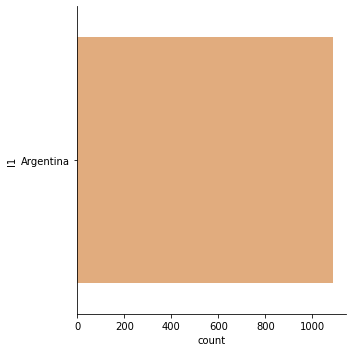

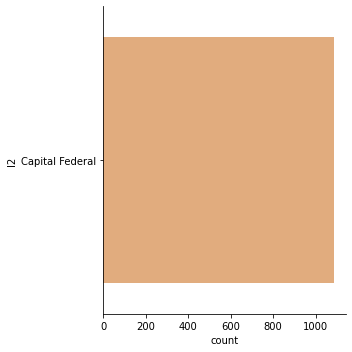

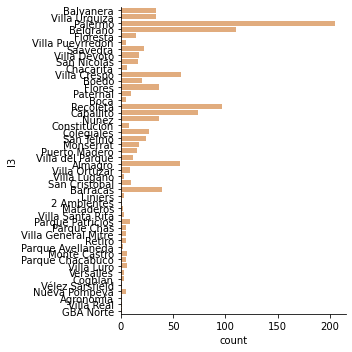

In [ ]:
sns.catplot(y = "l1", data = df_predecir, kind = "count", color='#F2AB6D')
sns.catplot(y = "l2", data = df_predecir, kind = "count", color='#F2AB6D')

sns.catplot(y = "l3", data = df_predecir, kind = "count", color='#F2AB6D')

Variables rooms, bed y bathrooms

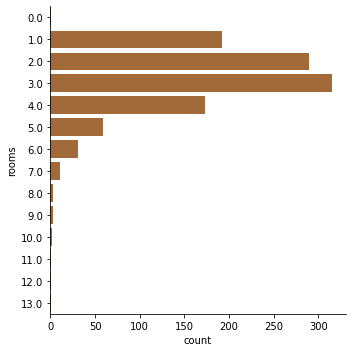

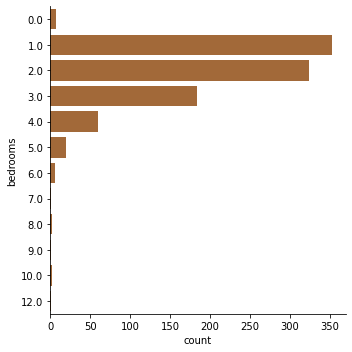

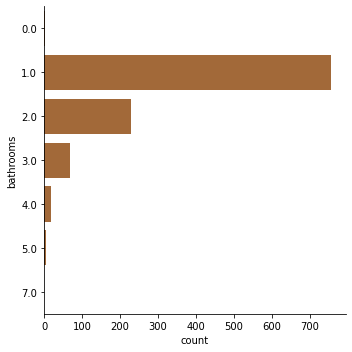

In [ ]:
sns.catplot(y = "rooms", data = df_predecir, kind = "count", color='#b36827')
sns.catplot(y = "bedrooms", data = df_predecir, kind = "count", color='#b36827')
sns.catplot(y = "bathrooms", data = df_predecir, kind = "count", color='#b36827')


Variable surface_total y surface_covered 


Text(0, 0.5, 'Frecuencia')

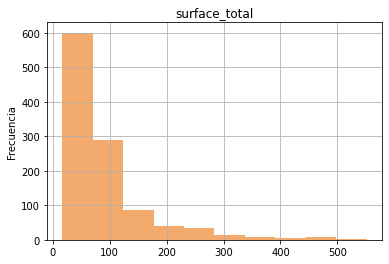

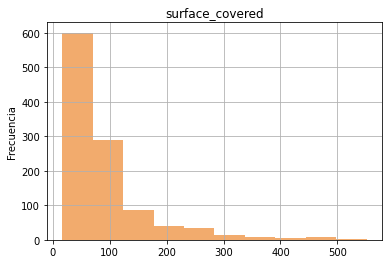

In [ ]:
df_predecir.hist('surface_total', color='#F2AB6D')
plt.title('surface_total')
plt.ylabel('Frecuencia')

df_predecir.hist('surface_covered', color='#F2AB6D')
plt.title('surface_covered')
plt.ylabel('Frecuencia')

#Mismos valores


In [ ]:
# Vemos el número de observaciones de la variable tipo de propiedad
df_predecir.groupby(['currency']).currency.agg('count')

currency
USD    1087
Name: currency, dtype: int64

In [ ]:
# Vemos el número de observaciones de la variable tipo de propiedad
df_predecir.groupby(['property_type']).property_type.agg('count')

property_type
Departamento    823
PH              264
Name: property_type, dtype: int64

In [ ]:
# Vemos el número de observaciones de la variable operation_type venta

df_predecir.groupby(['operation_type']).operation_type.agg('count')

operation_type
Venta    1087
Name: operation_type, dtype: int64

In [ ]:
df_predecir = df_predecir.rename(columns = {"lat":"longitud"})
df_predecir = df_predecir.rename(columns = {"lon":"latitud"})


In [ ]:
df_predecir = df_predecir.rename(columns = {"longitud":"lon"})
df_predecir = df_predecir.rename(columns = {"latitud":"lat"})

In [ ]:
df_predecir.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lon', 'lat',
       'l1', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'currency', 'price_period', 'title',
       'description', 'property_type', 'operation_type', 'details',
       'additionals', 'services', 'l4', 'l5', 'l6'],
      dtype='object')

# **Limpieza de datos y manejo de NaN datos a predecir**

In [ ]:
df_predecir["l3"].unique()

array(['Balvanera', 'Villa Urquiza', 'Palermo', 'Belgrano', 'Floresta',
       'Villa Pueyrredon', 'Saavedra', 'Villa Devoto', 'San Nicolás',
       'Chacarita', 'Villa Crespo', 'Boedo', 'Flores', 'Paternal', 'Boca',
       'Recoleta', 'Caballito', 'Nuñez', 'Constitución', 'Colegiales',
       'San Telmo', 'Monserrat', 'Puerto Madero', 'Villa del Parque',
       'Almagro', 'Villa Ortuzar', 'Villa Lugano', 'San Cristobal',
       'Barracas', 'Liniers', '2 Ambientes', 'Mataderos',
       'Villa Santa Rita', 'Parque Patricios', 'Parque Chas',
       'Villa General Mitre', 'Retiro', 'Parque Avellaneda',
       'Monte Castro', 'Parque Chacabuco', 'Villa Luro', 'Versalles',
       'Coghlan', 'Vélez Sarsfield', 'Nueva Pompeya', 'Agronomía',
       'Villa Real', 'GBA Norte'], dtype=object)

In [ ]:
#Remplazar l3 con 2 Ambientes a Palermo después de encontrar su ubicación
df_predecir["l3"] = df_predecir["l3"].replace({"2 Ambientes": "Palermo" })

In [ ]:
#Renombrar valores de barrios "l3"
df_predecir.replace('Parque Centenario', 'Caballito', inplace=True)
df_predecir.replace('Once', 'Balvanera', inplace=True)
df_predecir.replace('Catalinas', 'Boca', inplace=True)
df_predecir.replace('Las Cañitas', 'Palermo', inplace=True)
df_predecir.replace('Congreso', 'Balvanera', inplace=True)
df_predecir.replace('Tribunales', 'San Nicolas', inplace=True)
df_predecir.replace('San Nicolás', 'San Nicolas', inplace=True)
df_predecir.replace('Constitución', 'Constitucion', inplace=True)
df_predecir.replace('Agronomía', 'Agronomia', inplace=True)
df_predecir.replace('Vélez Sarsfield', 'Velez Sarsfield', inplace=True)
df_predecir.replace('GBA Norte', 'Recoleta', inplace=True)
df_predecir.replace('Centro / Microcentro', 'San Nicolas', inplace=True)
df_predecir.replace('Abasto', 'Almagro', inplace=True)
df_predecir.replace('Barrio Norte', 'Recoleta', inplace=True)
df_predecir.replace('Villa General Mitre', 'Villa Gral. Mitre', inplace=True)

Manejo de NaN en variables: rooms, bedrooms y bathrooms

* Sí hay valores NaN se les asigna el valor de 1, suponiendo que la propiedad tenga al menos 1 baño, 1 habitación.

In [ ]:
#Remplazamos los valores varios atipicos y los valores NaN
df_predecir["rooms"] = df["rooms"].replace({0: 1 })
df_predecir[['rooms']] = df_predecir[['rooms']].fillna(1)
df_predecir['rooms'].unique()

array([3.        , 2.        , 4.        , 1.        , 1.23375236,
       2.0445992 , 1.89654556, 6.        , 1.14460742, 8.        ,
       7.        , 3.30057619, 2.59746419, 1.51860519, 1.2821236 ,
       5.        , 2.44907529, 2.29117839, 2.76720947, 3.09054072,
       1.12937759, 1.61523179, 1.19383456, 1.63374804, 2.90726809,
       1.4741128 , 1.6700114 , 1.6387895 , 1.2644755 , 2.01673353,
       2.77650759, 1.3531499 , 1.48021146, 1.37360226, 2.31658359,
       1.36584832, 1.57969908, 1.48650021, 9.        , 2.89826685,
       2.88364859, 1.58578524, 1.79182139, 1.80569325, 3.39328634,
       1.37634478, 2.10519753, 2.52900658, 1.79553003, 1.47350531,
       3.12504603, 4.12778267, 1.71755946, 2.03568408, 1.27550322,
       3.0502818 , 1.0257185 , 1.32276272, 4.07267612, 2.58665143])

In [ ]:
#Remplazamos los valores varios atipicos y los valores NaN 
df_predecir["bedrooms"] = df["bedrooms"].replace({0: 1 })
df_predecir[['bedrooms']] = df_predecir[['bedrooms']].fillna(1)
df_predecir['bedrooms'].unique()

array([ 2.        ,  1.        ,  3.        ,  2.11699302,  1.1969061 ,
        0.81571069,  1.06304143,  4.        ,  1.32819154,  0.81563566,
        0.91558279,  0.83185368,  1.17854991,  1.96170005,  6.        ,
        1.22578233,  0.88214004,  0.89458071,  0.88310824,  0.74626069,
        0.74865878,  0.58438947,  2.766877  ,  0.86372594,  0.82171334,
        0.65836844,  1.53549378,  0.72441206,  2.49323913,  1.13252259,
        0.81053593,  2.94968653,  1.09101772,  0.97847198,  0.98819853,
        1.18899895,  1.30497444,  5.        ,  1.20016612,  1.63007831,
        1.19311541,  1.17966541,  0.48647803,  1.66289824,  7.        ,
        2.32967357,  1.51548466,  3.94775907,  1.19428395,  0.76472001,
        1.3152154 ,  0.08789426,  2.21116316,  0.9796277 ,  3.30511481,
        0.63065214,  0.89311625,  1.36599711,  1.12874287,  1.20310704,
        1.16480486,  1.15435813,  0.11397824,  0.10515925,  1.23302965,
        1.22582558,  1.55961026,  0.96180537,  0.68903111,  1.90

In [ ]:
#Remplazamos los valores vacios y outlier
df_predecir["bathrooms"] = df["bathrooms"].replace({0: 1 })
df_predecir[['bathrooms']] = df_predecir[['bathrooms']].fillna(1)
df_predecir['bathrooms'].unique()

array([1.        , 2.        , 3.        , 1.06310538, 4.        ,
       1.24850741, 2.29428032, 1.57698136, 1.06669954, 1.98023861,
       2.08657124, 1.14168239, 1.32067577, 1.14081933, 1.24355815,
       1.51558854, 1.08060776, 1.37407237, 1.14462752, 1.19074038,
       1.80853191, 1.56505695, 1.50237887, 1.99838323, 1.34136001,
       1.16691386, 1.13417716, 1.62463072, 2.7586066 , 1.13803864])

In [ ]:
df_predecir['barrio'] = df_predecir['l3'].str.title()

In [ ]:
df_predecir = df_predecir.merge(metricas_barrio, on='barrio')

In [ ]:
df_predecir.shape

(1087, 39)

# **Creación de variables datos a predecir**

In [ ]:
df_predecir["lprice"] = np.log(df_predecir['price'])

In [ ]:
df_predecir["price2"] = df_predecir['surface_total'] * df['m2_promedio']

In [ ]:
#Crear metrica de baños por habiración
df_predecir["bañ/hab"] = df_predecir['bathrooms'] * df_predecir['rooms']

Variable property_type a dummy

In [ ]:
#Variable dummy de property_type
df_predecir_property=pd.get_dummies(df_predecir, columns=["property_type"])
df_predecir_property.shape

(1087, 43)

Variable currency

In [ ]:
#Variable dummy de currency
df_predecir_currency=pd.get_dummies(df_predecir_property, columns=["currency"])
df_predecir_currency.shape

(1087, 43)

In [ ]:
df_predecir = df_predecir_currency
df_predecir.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lon', 'lat',
       'l1', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'price_period', 'title', 'description',
       'operation_type', 'details', 'additionals', 'services', 'l4', 'l5',
       'l6', 'barrio', 'comuna', 'sector', 'población', 'm2_promedio',
       'areas_verdes', 'robo con violencia', 'hurto', 'areas_verdes_percapita',
       'robo_violencia_año_10hab', 'hurto_año_10hab', 'lprice', 'price2',
       'bañ/hab', 'property_type_Departamento', 'property_type_PH',
       'currency_USD'],
      dtype='object')

**Variable de texto**

In [ ]:
#Pasar a minusculas
df_predecir["description"]=df_predecir["description"].str.lower()
df_predecir["description"][1]

'¡dos ambientes con dependencia en zona facultad de medicina! <br><br>descripción básica:<br>- dos ambientes contrafrente en pb.<br><br>superficies:<br>- cubierta: 61,05 m2.<br>-total: 61,05 m2.<br><br>descripción de ambientes:<br>- living comedor con vista al patio jardín..<br>- baño completo.<br>- habitación con placard.<br>-toilette.<br>-baño completo.<br>-dependencia.<br><br>descripción del edificio: <br>- edificio de 5 pisos.<br>- 2 unidades por piso.<br>- 1 ascensor.<br><br>gastos:<br>-expensas: $9.520.<br>-aysa: $500.<br><br>entrega:<br>- actualmente se encuentra deshabitado.<br>- la documentación de la propiedad está en condiciones para la compraventa. <br><br>accesibilidad:<br>-colectivos: 24, 26, 29, 41, 57, 60, 61, 62, 64, 68, 75, 95, 99, 101, 106, 109, 111, 115, 118, 124, 132, 140, 146, 180, 188, 194.<br>-subtes: córdoba (línea h), facultad de medicina (línea d), pasteur (línea b)<br><br><br>descripción del barrio:<br>-la propiedad se encuentra en el barrio balvanera, que p

In [ ]:
#se crea uan función que quita tilde y pasa texto a minúscula
def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

Crear variable que se llame balcón y que tenga en la descripción de la propiedad balcón

In [ ]:
#ahora buscamos si existe la palabra "balcón" en la variable descripcion y contamos
df_predecir["description"][df_predecir.description.str.contains('balcón',na=False)].count()

457

In [ ]:
df_predecir.description.str.contains('balcón',na=False)

0       False
1       False
2       False
3        True
4       False
        ...  
1082     True
1083     True
1084    False
1085    False
1086     True
Name: description, Length: 1087, dtype: bool

In [ ]:
#creamos una nueva variable que diga True o False en base a sentencia anterior 
df_predecir["balcon"]=df_predecir.description.str.contains('balcón',na=False)

In [ ]:
df_predecir["balcon"]=df_predecir.description.str.contains('balcón',na=False)

In [ ]:
#recodificamos
df_predecir['balcon']=[1 if i==True else 0 for i in df_predecir['balcon']]


In [ ]:
# verificamos la cantidad que quedaron con 1 que nos debe dar 457
df_predecir['balcon'].value_counts()

0    630
1    457
Name: balcon, dtype: int64

Variable dummy para aquellas propiedades que en la descripción mencionen tener aire acondicionado

In [ ]:
df_predecir["description"][df_predecir.description.str.contains('aire acondicionado',na=False)].count()

249

In [ ]:
df_predecir["aire_aco"]=df_predecir.description.str.contains('aire acondicionado',na=False)

In [ ]:
#recodificamos
df_predecir['aire_aco']=[1 if i==True else 0 for i in df_predecir['aire_aco']]

In [ ]:
# verificamos la cantidad que quedaron con 1 que nos debe dar 249
df_predecir['aire_aco'].value_counts()

0    838
1    249
Name: aire_aco, dtype: int64

Variable dummy para subte de la descripción de las variables

In [ ]:
df_predecir["description"][df_predecir.description.str.contains('subte',na=False)].count()

388

In [ ]:
df_predecir["subte_d"]=df_predecir.description.str.contains('subte',na=False)

In [ ]:
#recodificamos
df_predecir['subte_d']=[1 if i==True else 0 for i in df_predecir['subte_d']]

In [ ]:
# verificamos la cantidad que quedaron con 1 que nos debe dar 388
df_predecir['subte_d'].value_counts()

0    699
1    388
Name: subte_d, dtype: int64

Creamos variable terraza dummy que incluye en la descripcition

In [ ]:
df_predecir["description"][df_predecir.description.str.contains('terraza',na=False)].count()

404

In [ ]:
df_predecir["terraza"]=df_predecir.description.str.contains('terraza',na=False)

In [ ]:
#recodificamos
df_predecir['terraza']=[1 if i==True else 0 for i in df_predecir['terraza']]

In [ ]:
# verificamos la cantidad que quedaron con 1 que nos debe dar 404
df_predecir['terraza'].value_counts()

0    683
1    404
Name: terraza, dtype: int64

creamos una variable dummy para lo que mencionan tener cochera

In [ ]:
#ahora buscamos si existe la palabra "cochera" en la variable descripcion y contamos
df_predecir["description"][df_predecir.description.str.contains('cochera',na=False)].count()

280

In [ ]:
df_predecir.description.str.contains('cochera',na=False)

0       False
1       False
2       False
3       False
4       False
        ...  
1082     True
1083    False
1084    False
1085    False
1086    False
Name: description, Length: 1087, dtype: bool

In [ ]:
#creamos una nueva variable que diga True o False en base a sentencia anterior 
df_predecir["cochera"]=df_predecir.description.str.contains('cochera',na=False)

In [ ]:
df_predecir["cochera"]=df_predecir.description.str.contains('cochera',na=False)

In [ ]:
#recodificamos
df_predecir['cochera']=[1 if i==True else 0 for i in df_predecir['cochera']]

In [ ]:
# verificamos la cantidad que quedaron con 1 que nos debe dar 22,269
df_predecir['cochera'].value_counts()

0    807
1    280
Name: cochera, dtype: int64

creamos una variable dummy para lo que mencionan tener piscina

In [ ]:
#ahora buscamos si existe la palabra "piscina" en la variable descripcion y contamos
df_predecir["description"][df_predecir.description.str.contains('piscina',na=False)].count()

138

In [ ]:
df_predecir.description.str.contains('piscina',na=False)

0       False
1       False
2       False
3       False
4       False
        ...  
1082    False
1083    False
1084    False
1085    False
1086    False
Name: description, Length: 1087, dtype: bool

In [ ]:
#creamos una nueva variable que diga True o False en base a sentencia anterior 
df_predecir["piscina"]=df_predecir.description.str.contains('piscina',na=False)

In [ ]:
df_predecir["piscina"]=df_predecir.description.str.contains('piscina',na=False)

In [ ]:
#recodificamos
df_predecir['piscina']=[1 if i==True else 0 for i in df_predecir['piscina']]

In [ ]:
# verificamos la cantidad que quedaron con 1 
df_predecir['piscina'].value_counts()

0    949
1    138
Name: piscina, dtype: int64

Variable dummy de las propiedades donde menciona que menciona que tiene lavadero en la descripción

In [ ]:
#ahora buscamos si existe la palabra "lavadero" en la variable descripcion y contamos
df_predecir["description"][df_predecir.description.str.contains('lavadero',na=False)].count()

389

In [ ]:
df_predecir.description.str.contains('lavadero',na=False)

0        True
1       False
2       False
3        True
4       False
        ...  
1082    False
1083     True
1084     True
1085    False
1086     True
Name: description, Length: 1087, dtype: bool

In [ ]:
#creamos una nueva variable que diga True o False en base a sentencia anterior 
df_predecir["lavadero"]=df_predecir.description.str.contains('lavadero',na=False)

In [ ]:
df_predecir["lavadero"]=df_predecir.description.str.contains('lavadero',na=False)

In [ ]:
#recodificamos
df_predecir['lavadero']=[1 if i==True else 0 for i in df_predecir['lavadero']]


In [ ]:
# verificamos la cantidad que quedaron con 1 
df_predecir['lavadero'].value_counts()

0    698
1    389
Name: lavadero, dtype: int64

Variable dummy de las propiedades donde menciona que menciona que tiene un parque cercano en la descripción

In [ ]:
#ahora buscamos si existe la palabra "parque" en la variable descripcion y contamos
df_predecir["description"][df_predecir.description.str.contains('parque',na=False)].count()

227

In [ ]:
df_predecir.description.str.contains('parque',na=False)

0       False
1       False
2       False
3       False
4        True
        ...  
1082     True
1083    False
1084    False
1085    False
1086    False
Name: description, Length: 1087, dtype: bool

In [ ]:
#creamos una nueva variable que diga True o False en base a sentencia anterior 
df_predecir["parque"]=df_predecir.description.str.contains('parque',na=False)

In [ ]:
df_predecir["parque"]=df_predecir.description.str.contains('parque',na=False)

In [ ]:
#recodificamos
df_predecir['parque']=[1 if i==True else 0 for i in df_predecir['parque']]

In [ ]:
# verificamos la cantidad que quedaron con 1 que nos debe dar 49,954
df_predecir['parque'].value_counts()

0    860
1    227
Name: parque, dtype: int64

Variable dummy de las propiedades donde menciona que menciona que tiene seguridad en la descripción

In [ ]:
#ahora buscamos si existe la palabra "parque" en la variable descripcion y contamos
df_predecir["description"][df_predecir.description.str.contains('seguridad',na=False)].count()

168

In [ ]:
df_predecir.description.str.contains('seguridad',na=False)

0       False
1       False
2       False
3       False
4        True
        ...  
1082    False
1083    False
1084    False
1085    False
1086    False
Name: description, Length: 1087, dtype: bool

In [ ]:
#creamos una nueva variable que diga True o False en base a sentencia anterior 
df_predecir["seguridad"]=df_predecir.description.str.contains('seguridad',na=False)

In [ ]:
df_predecir["seguridad"]=df_predecir.description.str.contains('seguridad',na=False)

In [ ]:
#recodificamos
df_predecir['seguridad']=[1 if i==True else 0 for i in df_predecir['seguridad']]

In [ ]:
# verificamos la cantidad que quedaron con 1 que nos debe dar 11,174
df_predecir['seguridad'].value_counts()

0    919
1    168
Name: seguridad, dtype: int64

Variable dummy de las propiedades donde menciona que menciona estrenar

In [ ]:
#ahora buscamos si existe la palabra "parque" en la variable descripcion y contamos
df_predecir["description"][df_predecir.description.str.contains('a estrenar',na=False)].count()

50

In [ ]:
df_predecir.description.str.contains('a estrenar',na=False)

0       False
1       False
2       False
3       False
4       False
        ...  
1082    False
1083    False
1084    False
1085    False
1086    False
Name: description, Length: 1087, dtype: bool

In [ ]:
#creamos una nueva variable que diga True o False en base a sentencia anterior 
df_predecir["estrenar"]=df_predecir.description.str.contains('a estrenar',na=False)

In [ ]:
df_predecir["estrenar"]=df_predecir.description.str.contains('a estrenar',na=False)

In [ ]:
#recodificamos
df_predecir['estrenar']=[1 if i==True else 0 for i in df_predecir['estrenar']]

In [ ]:
# verificamos la cantidad que quedaron con 1 que nos debe dar 11,174
df_predecir['estrenar'].value_counts()

0    1037
1      50
Name: estrenar, dtype: int64

In [ ]:
df_predecir.shape

(1087, 53)

# **Datos extrenos**

In [ ]:
!wget https://cdn.buenosaires.gob.ar/datosabiertos/datasets/sbase/subte-estaciones/estaciones-de-subte.csv

--2022-09-22 21:11:08--  https://cdn.buenosaires.gob.ar/datosabiertos/datasets/sbase/subte-estaciones/estaciones-de-subte.csv
Resolving cdn.buenosaires.gob.ar (cdn.buenosaires.gob.ar)... 200.16.89.97
Connecting to cdn.buenosaires.gob.ar (cdn.buenosaires.gob.ar)|200.16.89.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5238 (5.1K) [text/csv]
Saving to: ‘estaciones-de-subte.csv.1’

estaciones-de-subte 100%[===================>]   5.12K  --.-KB/s    in 0s      

2022-09-22 21:11:09 (82.1 MB/s) - ‘estaciones-de-subte.csv.1’ saved [5238/5238]



In [ ]:
estaciones=pd.read_csv("/content/estaciones-de-subte.csv")

In [ ]:
estaciones

,long,lat,id,estacion,linea
0,-58.398928,-34.635750,1.0,CASEROS,H
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H
3,-58.404732,-34.615242,4.0,VENEZUELA,H
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H
...,...,...,...,...,...
85,-58.402376,-34.594525,86.0,SANTA FE - CARLOS JAUREGUI,H
86,-58.391019,-34.583036,87.0,FACULTAD DE DERECHO - JULIETA LANTERI,H
87,-58.375850,-34.592114,90.0,RETIRO,E
88,-58.371700,-34.596597,89.0,CATALINAS,E


La fórmula para calcular distancia lineal:\
Distancia en línea recta
= 6371 * ACOS(
              COS((Lat1 * 3,141592654)/180) * COS((Lat2 * 3,141592654)/180)          *    COS((Long2 * 3,141592654)/180) - (Long1 * 3,141592654)/180))
          + SIN((Lat1 * 3,141592654)/180) * SIN(Lat2 * 3,141592654)/180)) \
Donde:\
Lat 1, es el campo Latitud de cada estación, \
Long 1 , es el campo Longitud de cada estación \
Lat 2, es el campo Latitud del conjunto de datos \
Long 2, es el campo Longitud del conjunto de datos \

NOTA: la multiplicación por PI y dividir por 180 es para convertir una lat (o long) a distancia en mts


In [ ]:
import math

In [ ]:
math.pi

3.141592653589793

In [ ]:
from numpy import cos, sin
import math
#en el conjunto de datos de las estaciones, calculamos cos((Lat1 * 3,141592654)/180)) y cos((Long1 * 3,141592654)/180)) y también el seno

estaciones['long_1']= (estaciones['long']*math.pi)/180

estaciones['LAT1_cos']= cos((estaciones['lat']*math.pi)/180)

estaciones['LONG1_cos']=cos((estaciones['long']*math.pi)/180)

estaciones['LAT1_sen']= sin((estaciones['lat']*math.pi)/180)

estaciones['LONG1_sen']=sin((estaciones['long']*math.pi)/180)

In [ ]:
estaciones

,long,lat,id,estacion,linea,long_1,LAT1_cos,LONG1_cos,LAT1_sen,LONG1_sen
0,-58.398928,-34.635750,1.0,CASEROS,H,-1.019254,0.822782,0.524002,-0.568357,-0.851717
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,-1.019289,0.822845,0.523971,-0.568266,-0.851736
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,-1.019313,0.822907,0.523951,-0.568175,-0.851748
3,-58.404732,-34.615242,4.0,VENEZUELA,H,-1.019355,0.822985,0.523916,-0.568063,-0.851770
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,-1.019378,0.823048,0.523896,-0.567972,-0.851782
...,...,...,...,...,...,...,...,...,...,...
85,-58.402376,-34.594525,86.0,SANTA FE - CARLOS JAUREGUI,H,-1.019314,0.823191,0.523951,-0.567765,-0.851749
86,-58.391019,-34.583036,87.0,FACULTAD DE DERECHO - JULIETA LANTERI,H,-1.019116,0.823304,0.524119,-0.567600,-0.851645
87,-58.375850,-34.592114,90.0,RETIRO,E,-1.018851,0.823215,0.524345,-0.567730,-0.851506
88,-58.371700,-34.596597,89.0,CATALINAS,E,-1.018778,0.823170,0.524407,-0.567795,-0.851468


In [ ]:
#en el conjunto de datos, calculamos lo mismo

df_predecir['longitud_1']=(df_predecir['lon']*math.pi)/180

df_predecir['LATITUD_cos']= cos((df_predecir['lat']*math.pi)/180)

df_predecir['LONGITUD_cos']=cos((df_predecir['lon']*math.pi)/180)

df_predecir['LATITUD_sen']= sin((df_predecir['lat']*math.pi)/180)

df_predecir['LONGITUD_sen']=sin((df_predecir['lon']*math.pi)/180)

In [ ]:
df_predecir.head(2)

,id,ad_type,start_date,end_date,created_on,lon,lat,l1,l2,l3,...,piscina,lavadero,parque,seguridad,estrenar,longitud_1,LATITUD_cos,LONGITUD_cos,LATITUD_sen,LONGITUD_sen
0,1,Propiedad,01/04/2022,01/04/2022,01/04/2022,-58.407908,-34.601266,Argentina,Capital Federal,Balvanera,...,0,1,0,0,0,-1.019410,0.823124,0.523868,-0.567862,-0.851799
1,4,Propiedad,01/04/2022,01/04/2022,01/04/2022,-58.399793,-34.600414,Argentina,Capital Federal,Balvanera,...,0,0,0,0,0,-1.019269,0.823132,0.523989,-0.567850,-0.851725


In [ ]:
len(df_predecir)

1087

In [ ]:
#ahora, del conjunto de datos estaciones, solo nos quedamos con las variables recién calculadas

estaciones_1= estaciones.iloc[:,[5,6,7,8,9]]
#estaciones_1=pd.DataFrame.transpose(estaciones_1)

In [ ]:
estaciones_1

,long_1,LAT1_cos,LONG1_cos,LAT1_sen,LONG1_sen
0,-1.019254,0.822782,0.524002,-0.568357,-0.851717
1,-1.019289,0.822845,0.523971,-0.568266,-0.851736
2,-1.019313,0.822907,0.523951,-0.568175,-0.851748
3,-1.019355,0.822985,0.523916,-0.568063,-0.851770
4,-1.019378,0.823048,0.523896,-0.567972,-0.851782
...,...,...,...,...,...
85,-1.019314,0.823191,0.523951,-0.567765,-0.851749
86,-1.019116,0.823304,0.524119,-0.567600,-0.851645
87,-1.018851,0.823215,0.524345,-0.567730,-0.851506
88,-1.018778,0.823170,0.524407,-0.567795,-0.851468


In [ ]:
len(estaciones_1)

90

In [ ]:
#por cada registro del conjunto de datos (cada propiedad), se debe calcular la distancia a cada estación
#para eso, al conjunto de datos estaciones_1, le agregamos las 4 columnas traspuestas de las latitud y longitud recalculadas previamente.
#Cada una de estas columnas debe repetir el valor 90 veces, siendo el largo del conjunto estaciones_1

df_predecir.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lon', 'lat',
       'l1', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'price_period', 'title', 'description',
       'operation_type', 'details', 'additionals', 'services', 'l4', 'l5',
       'l6', 'barrio', 'comuna', 'sector', 'población', 'm2_promedio',
       'areas_verdes', 'robo con violencia', 'hurto', 'areas_verdes_percapita',
       'robo_violencia_año_10hab', 'hurto_año_10hab', 'lprice', 'price2',
       'bañ/hab', 'property_type_Departamento', 'property_type_PH',
       'currency_USD', 'balcon', 'aire_aco', 'subte_d', 'terraza', 'cochera',
       'piscina', 'lavadero', 'parque', 'seguridad', 'estrenar', 'longitud_1',
       'LATITUD_cos', 'LONGITUD_cos', 'LATITUD_sen', 'LONGITUD_sen'],
      dtype='object')

In [ ]:
df_predecir.shape

(1087, 58)

In [ ]:
#nso quedamos solo con las columnas que calculamos en data
prop_temp= pd.DataFrame(data.iloc[:,[52,53,54,55,56]])

In [ ]:
prop_temp

,longitud_1,LATITUD_cos,LONGITUD_cos,LATITUD_sen,LONGITUD_sen
0,-0.604007,0.823066,0.523916,-0.567945,-0.851770
1,-0.603884,0.823136,0.523875,-0.567844,-0.851795
2,-0.603989,0.823077,0.523979,-0.567930,-0.851731
3,-0.604010,0.823065,0.524002,-0.567948,-0.851717
4,-0.604115,0.823005,0.524109,-0.568034,-0.851651
...,...,...,...,...,...
93066,-0.605508,0.822213,0.522909,-0.569180,-0.852388
93067,-0.605463,0.822239,0.522948,-0.569143,-0.852365
93068,-0.605470,0.822234,0.523005,-0.569149,-0.852329
93069,-0.605612,0.822154,0.522945,-0.569265,-0.852366


In [ ]:
#le pegamos cada columna de estaciones_1, traspuesta (una columna por cada estación), repitiendo el valor 10 mil veces que es el largo de prop_temp

In [ ]:
import pandas as pd
LAT1_cos=pd.DataFrame.transpose(pd.DataFrame(estaciones_1['LAT1_cos']))

In [ ]:
LAT1_cos.columns=['H1.0LAT1_cos','H2.0LAT1_cos','H3.0LAT1_cos','H4.0LAT1_cos','H5.0LAT1_cos','D6.0LAT1_cos','D7.0LAT1_cos','D8.0LAT1_cos',
                  'D9.0LAT1_cos','D10.0LAT1_cos','D11.0LAT1_cos','D12.0LAT1_cos','C13.0LAT1_cos','C14.0LAT1_cos','C15.0LAT1_cos','C16.0LAT1_cos',
                  'C17.0LAT1_cos','C18.0LAT1_cos','C19.0LAT1_cos','B20.0LAT1_cos','B21.0LAT1_cos','B22.0LAT1_cos','B23.0LAT1_cos','B24.0LAT1_cos',
                  'B25.0LAT1_cos','B26.0LAT1_cos','B27.0LAT1_cos','B28.0LAT1_cos','B29.0LAT1_cos','B30.0LAT1_cos','A31.0LAT1_cos','A32.0LAT1_cos',
                  'A33.0LAT1_cos','A34.0LAT1_cos','A35.0LAT1_cos','A36.0LAT1_cos','A37.0LAT1_cos','A38.0LAT1_cos','A39.0LAT1_cos','A40.0LAT1_cos',
                  'A41.0LAT1_cos','A42.0LAT1_cos','A43.0LAT1_cos','E44.0LAT1_cos','E45.0LAT1_cos','E46.0LAT1_cos','E47.0LAT1_cos','E48.0LAT1_cos',
                  'E49.0LAT1_cos','E50.0LAT1_cos','E51.0LAT1_cos','E52.0LAT1_cos','E53.0LAT1_cos','D54.0LAT1_cos','D55.0LAT1_cos','D56.0LAT1_cos',
                  'C57.0LAT1_cos','C58.0LAT1_cos','E59.0LAT1_cos','E60.0LAT1_cos','E61.0LAT1_cos','D62.0LAT1_cos','D63.0LAT1_cos','D64.0LAT1_cos',
                  'D65.0LAT1_cos','B66.0LAT1_cos','E67.0LAT1_cos','E68.0LAT1_cos','D69.0LAT1_cos','A70.0LAT1_cos','D71.0LAT1_cos','B72.0LAT1_cos',
                  'B73.0LAT1_cos','B74.0LAT1_cos','A75.0LAT1_cos','A76.0LAT1_cos','H77.0LAT1_cos','H78.0LAT1_cos','H79.0LAT1_cos','B80.0LAT1_cos',
                  'B81.0LAT1_cos','A83.0LAT1_cos','A82.0LAT1_cos','H84.0LAT1_cos','H85.0LAT1_cos','H86.0LAT1_cos','H87.0LAT1_cos','E90.0LAT1_cos',
                  'E89.0LAT1_cos','E88.0LAT1_cos']

In [ ]:
LAT1_cos

,H1.0LAT1_cos,H2.0LAT1_cos,H3.0LAT1_cos,H4.0LAT1_cos,H5.0LAT1_cos,D6.0LAT1_cos,D7.0LAT1_cos,D8.0LAT1_cos,D9.0LAT1_cos,D10.0LAT1_cos,...,B81.0LAT1_cos,A83.0LAT1_cos,A82.0LAT1_cos,H84.0LAT1_cos,H85.0LAT1_cos,H86.0LAT1_cos,H87.0LAT1_cos,E90.0LAT1_cos,E89.0LAT1_cos,E88.0LAT1_cos
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106


In [ ]:
import numpy as np
LAT1_cos=pd.DataFrame(LAT1_cos.loc[np.repeat(LAT1_cos.index.values, 10000)])

In [ ]:
LAT1_cos

,H1.0LAT1_cos,H2.0LAT1_cos,H3.0LAT1_cos,H4.0LAT1_cos,H5.0LAT1_cos,D6.0LAT1_cos,D7.0LAT1_cos,D8.0LAT1_cos,D9.0LAT1_cos,D10.0LAT1_cos,...,B81.0LAT1_cos,A83.0LAT1_cos,A82.0LAT1_cos,H84.0LAT1_cos,H85.0LAT1_cos,H86.0LAT1_cos,H87.0LAT1_cos,E90.0LAT1_cos,E89.0LAT1_cos,E88.0LAT1_cos
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
LAT1_cos,0.822782,0.822845,0.822907,0.822985,0.823048,0.823094,0.823139,0.823121,0.823219,0.823283,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106


In [ ]:
LAT1_cos=LAT1_cos.reset_index(drop=True)

In [ ]:
cos_test=pd.concat([prop_temp, LAT1_cos], axis=1)

In [ ]:
cos_test

,longitud_1,LATITUD_cos,LONGITUD_cos,LATITUD_sen,LONGITUD_sen,H1.0LAT1_cos,H2.0LAT1_cos,H3.0LAT1_cos,H4.0LAT1_cos,H5.0LAT1_cos,...,B81.0LAT1_cos,A83.0LAT1_cos,A82.0LAT1_cos,H84.0LAT1_cos,H85.0LAT1_cos,H86.0LAT1_cos,H87.0LAT1_cos,E90.0LAT1_cos,E89.0LAT1_cos,E88.0LAT1_cos
0,-0.604007,0.823066,0.523916,-0.567945,-0.851770,0.822782,0.822845,0.822907,0.822985,0.823048,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
1,-0.603884,0.823136,0.523875,-0.567844,-0.851795,0.822782,0.822845,0.822907,0.822985,0.823048,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
2,-0.603989,0.823077,0.523979,-0.567930,-0.851731,0.822782,0.822845,0.822907,0.822985,0.823048,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
3,-0.604010,0.823065,0.524002,-0.567948,-0.851717,0.822782,0.822845,0.822907,0.822985,0.823048,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
4,-0.604115,0.823005,0.524109,-0.568034,-0.851651,0.822782,0.822845,0.822907,0.822985,0.823048,...,0.823391,0.822832,0.822848,0.823152,0.823261,0.823191,0.823304,0.823215,0.82317,0.823106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93066,-0.605508,0.822213,0.522909,-0.569180,-0.852388,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93067,-0.605463,0.822239,0.522948,-0.569143,-0.852365,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93068,-0.605470,0.822234,0.523005,-0.569149,-0.852329,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93069,-0.605612,0.822154,0.522945,-0.569265,-0.852366,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
estaciones_1.columns

Index(['long_1', 'LAT1_cos', 'LONG1_cos', 'LAT1_sen', 'LONG1_sen'], dtype='object')

In [ ]:
#seguimos con las otras
LONG1_cos=pd.DataFrame.transpose(pd.DataFrame(estaciones_1['LONG1_cos']))
LONG1_cos.columns=['H1.0LONG1_cos','H2.0LONG1_cos','H3.0LONG1_cos','H4.0LONG1_cos','H5.0LONG1_cos','D6.0LONG1_cos','D7.0LONG1_cos','D8.0LONG1_cos','D9.0LONG1_cos','D10.0LONG1_cos','D11.0LONG1_cos','D12.0LONG1_cos','C13.0LONG1_cos','C14.0LONG1_cos','C15.0LONG1_cos','C16.0LONG1_cos','C17.0LONG1_cos','C18.0LONG1_cos','C19.0LONG1_cos','B20.0LONG1_cos','B21.0LONG1_cos','B22.0LONG1_cos','B23.0LONG1_cos','B24.0LONG1_cos','B25.0LONG1_cos','B26.0LONG1_cos','B27.0LONG1_cos','B28.0LONG1_cos','B29.0LONG1_cos','B30.0LONG1_cos','A31.0LONG1_cos','A32.0LONG1_cos','A33.0LONG1_cos','A34.0LONG1_cos','A35.0LONG1_cos','A36.0LONG1_cos','A37.0LONG1_cos','A38.0LONG1_cos','A39.0LONG1_cos','A40.0LONG1_cos','A41.0LONG1_cos','A42.0LONG1_cos','A43.0LONG1_cos','E44.0LONG1_cos','E45.0LONG1_cos','E46.0LONG1_cos','E47.0LONG1_cos','E48.0LONG1_cos','E49.0LONG1_cos','E50.0LONG1_cos','E51.0LONG1_cos','E52.0LONG1_cos','E53.0LONG1_cos','D54.0LONG1_cos','D55.0LONG1_cos','D56.0LONG1_cos','C57.0LONG1_cos','C58.0LONG1_cos','E59.0LONG1_cos','E60.0LONG1_cos','E61.0LONG1_cos','D62.0LONG1_cos','D63.0LONG1_cos','D64.0LONG1_cos','D65.0LONG1_cos','B66.0LONG1_cos','E67.0LONG1_cos','E68.0LONG1_cos','D69.0LONG1_cos','A70.0LONG1_cos','D71.0LONG1_cos','B72.0LONG1_cos','B73.0LONG1_cos','B74.0LONG1_cos','A75.0LONG1_cos','A76.0LONG1_cos','H77.0LONG1_cos','H78.0LONG1_cos','H79.0LONG1_cos','B80.0LONG1_cos','B81.0LONG1_cos','A83.0LONG1_cos','A82.0LONG1_cos','H84.0LONG1_cos','H85.0LONG1_cos','H86.0LONG1_cos','H87.0LONG1_cos','E90.0LONG1_cos','E89.0LONG1_cos','E88.0LONG1_cos']
LONG1_cos=pd.DataFrame(LONG1_cos.loc[np.repeat(LONG1_cos.index.values, 10000)])
LONG1_cos=LONG1_cos.reset_index(drop=True)

In [ ]:
LAT1_sen=pd.DataFrame.transpose(pd.DataFrame(estaciones_1['LAT1_sen']))
LAT1_sen.columns=['H1.0LAT1_sen','H2.0LAT1_sen','H3.0LAT1_sen','H4.0LAT1_sen','H5.0LAT1_sen','D6.0LAT1_sen','D7.0LAT1_sen','D8.0LAT1_sen','D9.0LAT1_sen','D10.0LAT1_sen','D11.0LAT1_sen','D12.0LAT1_sen','C13.0LAT1_sen','C14.0LAT1_sen','C15.0LAT1_sen','C16.0LAT1_sen','C17.0LAT1_sen','C18.0LAT1_sen','C19.0LAT1_sen','B20.0LAT1_sen','B21.0LAT1_sen','B22.0LAT1_sen','B23.0LAT1_sen','B24.0LAT1_sen','B25.0LAT1_sen','B26.0LAT1_sen','B27.0LAT1_sen','B28.0LAT1_sen','B29.0LAT1_sen','B30.0LAT1_sen','A31.0LAT1_sen','A32.0LAT1_sen','A33.0LAT1_sen','A34.0LAT1_sen','A35.0LAT1_sen','A36.0LAT1_sen','A37.0LAT1_sen','A38.0LAT1_sen','A39.0LAT1_sen','A40.0LAT1_sen','A41.0LAT1_sen','A42.0LAT1_sen','A43.0LAT1_sen','E44.0LAT1_sen','E45.0LAT1_sen','E46.0LAT1_sen','E47.0LAT1_sen','E48.0LAT1_sen','E49.0LAT1_sen','E50.0LAT1_sen','E51.0LAT1_sen','E52.0LAT1_sen','E53.0LAT1_sen','D54.0LAT1_sen','D55.0LAT1_sen','D56.0LAT1_sen','C57.0LAT1_sen','C58.0LAT1_sen','E59.0LAT1_sen','E60.0LAT1_sen','E61.0LAT1_sen','D62.0LAT1_sen','D63.0LAT1_sen','D64.0LAT1_sen','D65.0LAT1_sen','B66.0LAT1_sen','E67.0LAT1_sen','E68.0LAT1_sen','D69.0LAT1_sen','A70.0LAT1_sen','D71.0LAT1_sen','B72.0LAT1_sen','B73.0LAT1_sen','B74.0LAT1_sen','A75.0LAT1_sen','A76.0LAT1_sen','H77.0LAT1_sen','H78.0LAT1_sen','H79.0LAT1_sen','B80.0LAT1_sen','B81.0LAT1_sen','A83.0LAT1_sen','A82.0LAT1_sen','H84.0LAT1_sen','H85.0LAT1_sen','H86.0LAT1_sen','H87.0LAT1_sen','E90.0LAT1_sen','E89.0LAT1_sen','E88.0LAT1_sen']
LAT1_sen=pd.DataFrame(LAT1_sen.loc[np.repeat(LAT1_sen.index.values, 10000)])
LAT1_sen=LAT1_sen.reset_index(drop=True)

In [ ]:
LONG1_sen=pd.DataFrame.transpose(pd.DataFrame(estaciones_1['LONG1_sen']))
LONG1_sen.columns=['H1.0LONG1_sen','H2.0LONG1_sen','H3.0LONG1_sen','H4.0LONG1_sen','H5.0LONG1_sen','D6.0LONG1_sen','D7.0LONG1_sen','D8.0LONG1_sen','D9.0LONG1_sen','D10.0LONG1_sen','D11.0LONG1_sen','D12.0LONG1_sen','C13.0LONG1_sen','C14.0LONG1_sen','C15.0LONG1_sen','C16.0LONG1_sen','C17.0LONG1_sen','C18.0LONG1_sen','C19.0LONG1_sen','B20.0LONG1_sen','B21.0LONG1_sen','B22.0LONG1_sen','B23.0LONG1_sen','B24.0LONG1_sen','B25.0LONG1_sen','B26.0LONG1_sen','B27.0LONG1_sen','B28.0LONG1_sen','B29.0LONG1_sen','B30.0LONG1_sen','A31.0LONG1_sen','A32.0LONG1_sen','A33.0LONG1_sen','A34.0LONG1_sen','A35.0LONG1_sen','A36.0LONG1_sen','A37.0LONG1_sen','A38.0LONG1_sen','A39.0LONG1_sen','A40.0LONG1_sen','A41.0LONG1_sen','A42.0LONG1_sen','A43.0LONG1_sen','E44.0LONG1_sen','E45.0LONG1_sen','E46.0LONG1_sen','E47.0LONG1_sen','E48.0LONG1_sen','E49.0LONG1_sen','E50.0LONG1_sen','E51.0LONG1_sen','E52.0LONG1_sen','E53.0LONG1_sen','D54.0LONG1_sen','D55.0LONG1_sen','D56.0LONG1_sen','C57.0LONG1_sen','C58.0LONG1_sen','E59.0LONG1_sen','E60.0LONG1_sen','E61.0LONG1_sen','D62.0LONG1_sen','D63.0LONG1_sen','D64.0LONG1_sen','D65.0LONG1_sen','B66.0LONG1_sen','E67.0LONG1_sen','E68.0LONG1_sen','D69.0LONG1_sen','A70.0LONG1_sen','D71.0LONG1_sen','B72.0LONG1_sen','B73.0LONG1_sen','B74.0LONG1_sen','A75.0LONG1_sen','A76.0LONG1_sen','H77.0LONG1_sen','H78.0LONG1_sen','H79.0LONG1_sen','B80.0LONG1_sen','B81.0LONG1_sen','A83.0LONG1_sen','A82.0LONG1_sen','H84.0LONG1_sen','H85.0LONG1_sen','H86.0LONG1_sen','H87.0LONG1_sen','E90.0LONG1_sen','E89.0LONG1_sen','E88.0LONG1_sen']
LONG1_sen=pd.DataFrame(LONG1_sen.loc[np.repeat(LONG1_sen.index.values, 10000)])
LONG1_sen=LONG1_sen.reset_index(drop=True)

In [ ]:
longi=pd.DataFrame.transpose(pd.DataFrame(estaciones_1['long_1']))
longi.columns=['longiH1.0','longiH2.0','longiH3.0','longiH4.0','longiH5.0','longiD6.0','longiD7.0','longiD8.0',
'longiD9.0','longiD10.0','longiD11.0','longiD12.0','longiC13.0','longiC14.0','longiC15.0','longiC16.0','longiC17.0','longiC18.0',
'longiC19.0','longiB20.0','longiB21.0','longiB22.0','longiB23.0','longiB24.0','longiB25.0','longiB26.0','longiB27.0','longiB28.0',
'longiB29.0','longiB30.0','longiA31.0','longiA32.0','longiA33.0','longiA34.0','longiA35.0','longiA36.0','longiA37.0','longiA38.0','longiA39.0',
'longiA40.0','longiA41.0','longiA42.0','longiA43.0','longiE44.0','longiE45.0','longiE46.0','longiE47.0','longiE48.0','longiE49.0','longiE50.0',
'longiE51.0','longiE52.0','longiE53.0','longiD54.0','longiD55.0','longiD56.0','longiC57.0','longiC58.0','longiE59.0','longiE60.0','longiE61.0','longiD62.0',
'longiD63.0','longiD64.0','longiD65.0','longiB66.0','longiE67.0','longiE68.0','longiD69.0','longiA70.0','longiD71.0','longiB72.0','longiB73.0','longiB74.0','longiA75.0',
'longiA76.0','longiH77.0','longiH78.0','longiH79.0','longiB80.0','longiB81.0','longiA83.0','longiA82.0','longiH84.0','longiH85.0','longiH86.0',
'longiH87.0','longiE90.0','longiE89.0','longiE88.0']
longi=pd.DataFrame(longi.loc[np.repeat(longi.index.values, 10000)])
longi=longi.reset_index(drop=True)

In [ ]:
para_calculos=pd.concat([prop_temp, LAT1_cos, LONG1_cos, LAT1_sen, LONG1_sen,longi], axis=1)

In [ ]:
para_calculos

,longitud_1,LATITUD_cos,LONGITUD_cos,LATITUD_sen,LONGITUD_sen,H1.0LAT1_cos,H2.0LAT1_cos,H3.0LAT1_cos,H4.0LAT1_cos,H5.0LAT1_cos,...,longiB81.0,longiA83.0,longiA82.0,longiH84.0,longiH85.0,longiH86.0,longiH87.0,longiE90.0,longiE89.0,longiE88.0
0,-0.604007,0.823066,0.523916,-0.567945,-0.851770,0.822782,0.822845,0.822907,0.822985,0.823048,...,-1.02078,-1.020488,-1.020381,-1.019337,-1.019224,-1.019314,-1.019116,-1.018851,-1.018778,-1.018756
1,-0.603884,0.823136,0.523875,-0.567844,-0.851795,0.822782,0.822845,0.822907,0.822985,0.823048,...,-1.02078,-1.020488,-1.020381,-1.019337,-1.019224,-1.019314,-1.019116,-1.018851,-1.018778,-1.018756
2,-0.603989,0.823077,0.523979,-0.567930,-0.851731,0.822782,0.822845,0.822907,0.822985,0.823048,...,-1.02078,-1.020488,-1.020381,-1.019337,-1.019224,-1.019314,-1.019116,-1.018851,-1.018778,-1.018756
3,-0.604010,0.823065,0.524002,-0.567948,-0.851717,0.822782,0.822845,0.822907,0.822985,0.823048,...,-1.02078,-1.020488,-1.020381,-1.019337,-1.019224,-1.019314,-1.019116,-1.018851,-1.018778,-1.018756
4,-0.604115,0.823005,0.524109,-0.568034,-0.851651,0.822782,0.822845,0.822907,0.822985,0.823048,...,-1.02078,-1.020488,-1.020381,-1.019337,-1.019224,-1.019314,-1.019116,-1.018851,-1.018778,-1.018756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93066,-0.605508,0.822213,0.522909,-0.569180,-0.852388,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93067,-0.605463,0.822239,0.522948,-0.569143,-0.852365,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93068,-0.605470,0.822234,0.523005,-0.569149,-0.852329,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93069,-0.605612,0.822154,0.522945,-0.569265,-0.852366,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
para_calculos.shape

(93071, 455)

In [ ]:
para_calculos.columns

Index(['longitud_1', 'LATITUD_cos', 'LONGITUD_cos', 'LATITUD_sen',
       'LONGITUD_sen', 'H1.0LAT1_cos', 'H2.0LAT1_cos', 'H3.0LAT1_cos',
       'H4.0LAT1_cos', 'H5.0LAT1_cos',
       ...
       'longiB81.0', 'longiA83.0', 'longiA82.0', 'longiH84.0', 'longiH85.0',
       'longiH86.0', 'longiH87.0', 'longiE90.0', 'longiE89.0', 'longiE88.0'],
      dtype='object', length=455)

In [ ]:
#calculamos la distancia para cada estación por cada propiedad (tiene que ser 90 columnas de distancia)
#  Distancia en línea recta = 6371 * ACOS(COS((Lat1 * 3,141592654)/180) * COS((Lat2 * 3,141592654)/180) * COS((Long2 * 3,141592654)/180) - (Long1 * 3,141592654)/180)) + SIN((Lat1 * 3,141592654)/180) * SIN(Lat2 * 3,141592654)/180))

from numpy import arccos
para_calculos['DH1.0']=6371*(np.arccos((para_calculos['H1.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH1.0'])))
                                       + (para_calculos['H1.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

In [ ]:
para_calculos['DH1.0'] #distancia de cada propiedad a la estación ID=1.0 (CASEROS, eso lo ven en el excel de estaciones importado) de la línea H

0        2171.972617
1        2172.706022
2        2172.081309
3        2171.952852
4        2171.331018
            ...     
93066            NaN
93067            NaN
93068            NaN
93069            NaN
93070            NaN
Name: DH1.0, Length: 93071, dtype: float64

In [ ]:
para_calculos['DH1.0'].max()

2273.810013913361

In [ ]:
para_calculos['DH1.0'].min()

2167.3074125571784

In [ ]:
#continuamos con las 89 restantes

para_calculos['DH2.0']=6371*(np.arccos((para_calculos['H2.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH2.0'])))
                                       + (para_calculos['H2.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH3.0']=6371*(np.arccos((para_calculos['H3.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH3.0'])))
                                       + (para_calculos['H3.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH4.0']=6371*(np.arccos((para_calculos['H4.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH4.0'])))
                                       + (para_calculos['H4.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH5.0']=6371*(np.arccos((para_calculos['H5.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH5.0'])))
                                       + (para_calculos['H5.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD6.0']=6371*(np.arccos((para_calculos['D6.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD6.0'])))
                                       + (para_calculos['D6.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD7.0']=6371*(np.arccos((para_calculos['D7.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD7.0'])))
                                       + (para_calculos['D7.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD8.0']=6371*(np.arccos((para_calculos['D8.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD8.0'])))
                                       + (para_calculos['D8.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD9.0']=6371*(np.arccos((para_calculos['D9.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD9.0'])))
                                       + (para_calculos['D9.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD10.0']=6371*(np.arccos((para_calculos['D10.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD10.0'])))
                                       + (para_calculos['D10.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD11.0']=6371*(np.arccos((para_calculos['D11.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD11.0'])))
                                       + (para_calculos['D11.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD12.0']=6371*(np.arccos((para_calculos['D12.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD12.0'])))
                                       + (para_calculos['D12.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC13.0']=6371*(np.arccos((para_calculos['C13.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC13.0'])))
                                       + (para_calculos['C13.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC14.0']=6371*(np.arccos((para_calculos['C14.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC14.0'])))
                                       + (para_calculos['C14.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC15.0']=6371*(np.arccos((para_calculos['C15.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC15.0'])))
                                       + (para_calculos['C15.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC16.0']=6371*(np.arccos((para_calculos['C16.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC16.0'])))
                                       + (para_calculos['C16.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC17.0']=6371*(np.arccos((para_calculos['C17.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC17.0'])))
                                       + (para_calculos['C17.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC18.0']=6371*(np.arccos((para_calculos['C18.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC18.0'])))
                                       + (para_calculos['C18.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC19.0']=6371*(np.arccos((para_calculos['C19.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC19.0'])))
                                       + (para_calculos['C19.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB20.0']=6371*(np.arccos((para_calculos['B20.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB20.0'])))
                                       + (para_calculos['B20.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB21.0']=6371*(np.arccos((para_calculos['B21.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB21.0'])))
                                       + (para_calculos['B21.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB22.0']=6371*(np.arccos((para_calculos['B22.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB22.0'])))
                                       + (para_calculos['B22.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB23.0']=6371*(np.arccos((para_calculos['B23.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB23.0'])))
                                       + (para_calculos['B23.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB24.0']=6371*(np.arccos((para_calculos['B24.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB24.0'])))
                                       + (para_calculos['B24.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB25.0']=6371*(np.arccos((para_calculos['B25.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB25.0'])))
                                       + (para_calculos['B25.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB26.0']=6371*(np.arccos((para_calculos['B26.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB26.0'])))
                                       + (para_calculos['B26.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB27.0']=6371*(np.arccos((para_calculos['B27.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB27.0'])))
                                       + (para_calculos['B27.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB28.0']=6371*(np.arccos((para_calculos['B28.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB28.0'])))
                                       + (para_calculos['B28.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB29.0']=6371*(np.arccos((para_calculos['B29.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB29.0'])))
                                       + (para_calculos['B29.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB30.0']=6371*(np.arccos((para_calculos['B30.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB30.0'])))
                                       + (para_calculos['B30.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA31.0']=6371*(np.arccos((para_calculos['A31.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA31.0'])))
                                       + (para_calculos['A31.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA32.0']=6371*(np.arccos((para_calculos['A32.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA32.0'])))
                                       + (para_calculos['A32.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA33.0']=6371*(np.arccos((para_calculos['A33.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA33.0'])))
                                       + (para_calculos['A33.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA34.0']=6371*(np.arccos((para_calculos['A34.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA34.0'])))
                                       + (para_calculos['A34.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA35.0']=6371*(np.arccos((para_calculos['A35.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA35.0'])))
                                       + (para_calculos['A35.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA36.0']=6371*(np.arccos((para_calculos['A36.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA36.0'])))
                                       + (para_calculos['A36.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA37.0']=6371*(np.arccos((para_calculos['A37.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA37.0'])))
                                       + (para_calculos['A37.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA38.0']=6371*(np.arccos((para_calculos['A38.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA38.0'])))
                                       + (para_calculos['A38.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA39.0']=6371*(np.arccos((para_calculos['A39.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA39.0'])))
                                       + (para_calculos['A39.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA40.0']=6371*(np.arccos((para_calculos['A40.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA40.0'])))
                                       + (para_calculos['A40.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA41.0']=6371*(np.arccos((para_calculos['A41.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA41.0'])))
                                       + (para_calculos['A41.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA42.0']=6371*(np.arccos((para_calculos['A42.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longiA42.0']-para_calculos['longitud_1'])))
                                       + (para_calculos['A42.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA43.0']=6371*(np.arccos((para_calculos['A43.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA43.0'])))
                                       + (para_calculos['A43.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE44.0']=6371*(np.arccos((para_calculos['E44.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE44.0'])))
                                       + (para_calculos['E44.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE45.0']=6371*(np.arccos((para_calculos['E45.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE45.0'])))
                                       + (para_calculos['E45.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE46.0']=6371*(np.arccos((para_calculos['E46.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE46.0'])))
                                       + (para_calculos['E46.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE47.0']=6371*(np.arccos((para_calculos['E47.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE47.0'])))
                                       + (para_calculos['E47.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE48.0']=6371*(np.arccos((para_calculos['E48.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE48.0'])))
                                       + (para_calculos['E48.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE49.0']=6371*(np.arccos((para_calculos['E49.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE49.0'])))
                                       + (para_calculos['E49.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE50.0']=6371*(np.arccos((para_calculos['E50.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE50.0'])))
                                       + (para_calculos['E50.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE51.0']=6371*(np.arccos((para_calculos['E51.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE51.0'])))
                                       + (para_calculos['E51.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE52.0']=6371*(np.arccos((para_calculos['E52.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE52.0'])))
                                       + (para_calculos['E52.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE53.0']=6371*(np.arccos((para_calculos['E53.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE53.0'])))
                                       + (para_calculos['E53.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD54.0']=6371*(np.arccos((para_calculos['D54.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD54.0'])))
                                       + (para_calculos['D54.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD55.0']=6371*(np.arccos((para_calculos['D55.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD55.0'])))
                                       + (para_calculos['D55.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD56.0']=6371*(np.arccos((para_calculos['D56.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD56.0'])))
                                       + (para_calculos['D56.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC57.0']=6371*(np.arccos((para_calculos['C57.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC57.0'])))
                                       + (para_calculos['C57.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DC58.0']=6371*(np.arccos((para_calculos['C58.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiC58.0'])))
                                       + (para_calculos['C58.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE59.0']=6371*(np.arccos((para_calculos['E59.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE59.0'])))
                                       + (para_calculos['E59.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE60.0']=6371*(np.arccos((para_calculos['E60.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE60.0'])))
                                       + (para_calculos['E60.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE61.0']=6371*(np.arccos((para_calculos['E61.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE61.0'])))
                                       + (para_calculos['E61.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD62.0']=6371*(np.arccos((para_calculos['D62.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD62.0'])))
                                       + (para_calculos['D62.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD63.0']=6371*(np.arccos((para_calculos['D63.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD63.0'])))
                                       + (para_calculos['D63.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD64.0']=6371*(np.arccos((para_calculos['D64.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD64.0'])))
                                       + (para_calculos['D64.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD65.0']=6371*(np.arccos((para_calculos['D65.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD65.0'])))
                                       + (para_calculos['D65.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB66.0']=6371*(np.arccos((para_calculos['B66.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB66.0'])))
                                       + (para_calculos['B66.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE67.0']=6371*(np.arccos((para_calculos['E67.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE67.0'])))
                                       + (para_calculos['E67.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE68.0']=6371*(np.arccos((para_calculos['E68.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE68.0'])))
                                       + (para_calculos['E68.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD69.0']=6371*(np.arccos((para_calculos['D69.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD69.0'])))
                                       + (para_calculos['D69.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA70.0']=6371*(np.arccos((para_calculos['A70.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA70.0'])))
                                       + (para_calculos['A70.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DD71.0']=6371*(np.arccos((para_calculos['D71.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiD71.0'])))
                                       + (para_calculos['D71.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB72.0']=6371*(np.arccos((para_calculos['B72.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB72.0'])))
                                       + (para_calculos['B72.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB73.0']=6371*(np.arccos((para_calculos['B73.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB73.0'])))
                                       + (para_calculos['B73.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB74.0']=6371*(np.arccos((para_calculos['B74.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB74.0'])))
                                       + (para_calculos['B74.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA75.0']=6371*(np.arccos((para_calculos['A75.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA75.0'])))
                                       + (para_calculos['A75.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA76.0']=6371*(np.arccos((para_calculos['A76.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA76.0'])))
                                       + (para_calculos['A76.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH77.0']=6371*(np.arccos((para_calculos['H77.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH77.0'])))
                                       + (para_calculos['H77.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH78.0']=6371*(np.arccos((para_calculos['H78.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH78.0'])))
                                       + (para_calculos['H78.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH79.0']=6371*(np.arccos((para_calculos['H79.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH79.0'])))
                                       + (para_calculos['H79.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB80.0']=6371*(np.arccos((para_calculos['B80.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB80.0'])))
                                       + (para_calculos['B80.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DB81.0']=6371*(np.arccos((para_calculos['B81.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiB81.0'])))
                                       + (para_calculos['B81.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA83.0']=6371*(np.arccos((para_calculos['A83.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA83.0'])))
                                       + (para_calculos['A83.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DA82.0']=6371*(np.arccos((para_calculos['A82.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiA82.0'])))
                                       + (para_calculos['A82.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH84.0']=6371*(np.arccos((para_calculos['H84.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH84.0'])))
                                       + (para_calculos['H84.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH85.0']=6371*(np.arccos((para_calculos['H85.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH85.0'])))
                                       + (para_calculos['H85.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH86.0']=6371*(np.arccos((para_calculos['H86.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH86.0'])))
                                       + (para_calculos['H86.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DH87.0']=6371*(np.arccos((para_calculos['H87.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiH87.0'])))
                                       + (para_calculos['H87.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE90.0']=6371*(np.arccos((para_calculos['E90.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE90.0'])))
                                       + (para_calculos['E90.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE89.0']=6371*(np.arccos((para_calculos['E89.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE89.0'])))
                                       + (para_calculos['E89.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

para_calculos['DE88.0']=6371*(np.arccos((para_calculos['E88.0LAT1_cos'] * para_calculos['LATITUD_cos'] * (cos(para_calculos['longitud_1']-para_calculos['longiE88.0'])))
                                       + (para_calculos['E88.0LAT1_sen'] * para_calculos['LATITUD_sen'])))

In [ ]:
para_calculos  #el cálculo que devuelve está expresado en km

,longitud_1,LATITUD_cos,LONGITUD_cos,LATITUD_sen,LONGITUD_sen,H1.0LAT1_cos,H2.0LAT1_cos,H3.0LAT1_cos,H4.0LAT1_cos,H5.0LAT1_cos,...,DB81.0,DA83.0,DA82.0,DH84.0,DH85.0,DH86.0,DH87.0,DE90.0,DE89.0,DE88.0
0,-0.604007,0.823066,0.523916,-0.567945,-0.851770,0.822782,0.822845,0.822907,0.822985,0.823048,...,2180.733674,2178.463232,2177.930350,2172.898902,2172.453704,2172.828783,2171.949474,2170.450057,2170.013491,2169.811538
1,-0.603884,0.823136,0.523875,-0.567844,-0.851795,0.822782,0.822845,0.822907,0.822985,0.823048,...,2181.465167,2179.196704,2178.663742,2173.630972,2173.185352,2173.560706,2172.680939,2171.181797,2170.745378,2170.543654
2,-0.603989,0.823077,0.523979,-0.567930,-0.851731,0.822782,0.822845,0.822907,0.822985,0.823048,...,2180.842082,2178.571934,2178.039040,2173.007396,2172.562135,2172.937255,2172.057878,2170.558502,2170.121957,2169.920039
3,-0.604010,0.823065,0.524002,-0.567948,-0.851717,0.822782,0.822845,0.822907,0.822985,0.823048,...,2180.713960,2178.443465,2177.910586,2172.879173,2172.433987,2172.809059,2171.929762,2170.430338,2169.993767,2169.791808
4,-0.604115,0.823005,0.524109,-0.568034,-0.851651,0.822782,0.822845,0.822907,0.822985,0.823048,...,2180.093748,2177.821574,2177.288762,2172.258472,2171.813644,2172.188483,2171.309575,2169.809917,2169.373221,2169.171068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93066,-0.605508,0.822213,0.522909,-0.569180,-0.852388,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93067,-0.605463,0.822239,0.522948,-0.569143,-0.852365,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93068,-0.605470,0.822234,0.523005,-0.569149,-0.852329,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93069,-0.605612,0.822154,0.522945,-0.569265,-0.852366,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Como ya tenemos la distancia de cada propiedad a cada estación, recodificamos,  con 1 si la estación de subte está a 500 mts o menos, 0 en caso contrario

In [ ]:
para_calculos['H1.0']=[0 if i>0.5 else 1 for i in para_calculos['DH1.0']]

In [ ]:
para_calculos['H1.0'].unique()

array([0, 1])

In [ ]:
para_calculos.groupby('H1.0').count() #hay 9990 propiedades que no tienen la estación CASEROS de la Línea H a 500 mts o menos; y hay 10 propiedades que si

,longitud_1,LATITUD_cos,LONGITUD_cos,LATITUD_sen,LONGITUD_sen,H1.0LAT1_cos,H2.0LAT1_cos,H3.0LAT1_cos,H4.0LAT1_cos,H5.0LAT1_cos,...,DB81.0,DA83.0,DA82.0,DH84.0,DH85.0,DH86.0,DH87.0,DE90.0,DE89.0,DE88.0
H1.0,,,,,,,,,,,,,,,,,,,,,
0,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
1,83071,83071,83071,83071,83071,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#calculamos para las restantes 89 estaciones
para_calculos['H2.0']=[0 if i>0.5 else 1 for i in para_calculos['DH2.0']]
para_calculos['H3.0']=[0 if i>0.5 else 1 for i in para_calculos['DH3.0']]
para_calculos['H4.0']=[0 if i>0.5 else 1 for i in para_calculos['DH4.0']]
para_calculos['H5.0']=[0 if i>0.5 else 1 for i in para_calculos['DH5.0']]
para_calculos['D6.0']=[0 if i>0.5 else 1 for i in para_calculos['DD6.0']]
para_calculos['D7.0']=[0 if i>0.5 else 1 for i in para_calculos['DD7.0']]
para_calculos['D8.0']=[0 if i>0.5 else 1 for i in para_calculos['DD8.0']]
para_calculos['D9.0']=[0 if i>0.5 else 1 for i in para_calculos['DD9.0']]
para_calculos['D10.0']=[0 if i>0.5 else 1 for i in para_calculos['DD10.0']]
para_calculos['D11.0']=[0 if i>0.5 else 1 for i in para_calculos['DD11.0']]
para_calculos['D12.0']=[0 if i>0.5 else 1 for i in para_calculos['DD12.0']]
para_calculos['C13.0']=[0 if i>0.5 else 1 for i in para_calculos['DC13.0']]
para_calculos['C14.0']=[0 if i>0.5 else 1 for i in para_calculos['DC14.0']]
para_calculos['C15.0']=[0 if i>0.5 else 1 for i in para_calculos['DC15.0']]
para_calculos['C16.0']=[0 if i>0.5 else 1 for i in para_calculos['DC16.0']]
para_calculos['C17.0']=[0 if i>0.5 else 1 for i in para_calculos['DC17.0']]
para_calculos['C18.0']=[0 if i>0.5 else 1 for i in para_calculos['DC18.0']]
para_calculos['C19.0']=[0 if i>0.5 else 1 for i in para_calculos['DC19.0']]
para_calculos['B20.0']=[0 if i>0.5 else 1 for i in para_calculos['DB20.0']]
para_calculos['B21.0']=[0 if i>0.5 else 1 for i in para_calculos['DB21.0']]
para_calculos['B22.0']=[0 if i>0.5 else 1 for i in para_calculos['DB22.0']]
para_calculos['B23.0']=[0 if i>0.5 else 1 for i in para_calculos['DB23.0']]
para_calculos['B24.0']=[0 if i>0.5 else 1 for i in para_calculos['DB24.0']]
para_calculos['B25.0']=[0 if i>0.5 else 1 for i in para_calculos['DB25.0']]
para_calculos['B26.0']=[0 if i>0.5 else 1 for i in para_calculos['DB26.0']]
para_calculos['B27.0']=[0 if i>0.5 else 1 for i in para_calculos['DB27.0']]
para_calculos['B28.0']=[0 if i>0.5 else 1 for i in para_calculos['DB28.0']]
para_calculos['B29.0']=[0 if i>0.5 else 1 for i in para_calculos['DB29.0']]
para_calculos['B30.0']=[0 if i>0.5 else 1 for i in para_calculos['DB30.0']]
para_calculos['A31.0']=[0 if i>0.5 else 1 for i in para_calculos['DA31.0']]
para_calculos['A32.0']=[0 if i>0.5 else 1 for i in para_calculos['DA32.0']]
para_calculos['A33.0']=[0 if i>0.5 else 1 for i in para_calculos['DA33.0']]
para_calculos['A34.0']=[0 if i>0.5 else 1 for i in para_calculos['DA34.0']]
para_calculos['A35.0']=[0 if i>0.5 else 1 for i in para_calculos['DA35.0']]
para_calculos['A36.0']=[0 if i>0.5 else 1 for i in para_calculos['DA36.0']]
para_calculos['A37.0']=[0 if i>0.5 else 1 for i in para_calculos['DA37.0']]
para_calculos['A38.0']=[0 if i>0.5 else 1 for i in para_calculos['DA38.0']]
para_calculos['A39.0']=[0 if i>0.5 else 1 for i in para_calculos['DA39.0']]
para_calculos['A40.0']=[0 if i>0.5 else 1 for i in para_calculos['DA40.0']]
para_calculos['A41.0']=[0 if i>0.5 else 1 for i in para_calculos['DA41.0']]
para_calculos['A42.0']=[0 if i>0.5 else 1 for i in para_calculos['DA42.0']]
para_calculos['A43.0']=[0 if i>0.5 else 1 for i in para_calculos['DA43.0']]
para_calculos['E44.0']=[0 if i>0.5 else 1 for i in para_calculos['DE44.0']]
para_calculos['E45.0']=[0 if i>0.5 else 1 for i in para_calculos['DE45.0']]
para_calculos['E46.0']=[0 if i>0.5 else 1 for i in para_calculos['DE46.0']]
para_calculos['E47.0']=[0 if i>0.5 else 1 for i in para_calculos['DE47.0']]
para_calculos['E48.0']=[0 if i>0.5 else 1 for i in para_calculos['DE48.0']]
para_calculos['E49.0']=[0 if i>0.5 else 1 for i in para_calculos['DE49.0']]
para_calculos['E50.0']=[0 if i>0.5 else 1 for i in para_calculos['DE50.0']]
para_calculos['E51.0']=[0 if i>0.5 else 1 for i in para_calculos['DE51.0']]
para_calculos['E52.0']=[0 if i>0.5 else 1 for i in para_calculos['DE52.0']]
para_calculos['E53.0']=[0 if i>0.5 else 1 for i in para_calculos['DE53.0']]
para_calculos['D54.0']=[0 if i>0.5 else 1 for i in para_calculos['DD54.0']]
para_calculos['D55.0']=[0 if i>0.5 else 1 for i in para_calculos['DD55.0']]
para_calculos['D56.0']=[0 if i>0.5 else 1 for i in para_calculos['DD56.0']]
para_calculos['C57.0']=[0 if i>0.5 else 1 for i in para_calculos['DC57.0']]
para_calculos['C58.0']=[0 if i>0.5 else 1 for i in para_calculos['DC58.0']]
para_calculos['E59.0']=[0 if i>0.5 else 1 for i in para_calculos['DE59.0']]
para_calculos['E60.0']=[0 if i>0.5 else 1 for i in para_calculos['DE60.0']]
para_calculos['E61.0']=[0 if i>0.5 else 1 for i in para_calculos['DE61.0']]
para_calculos['D62.0']=[0 if i>0.5 else 1 for i in para_calculos['DD62.0']]
para_calculos['D63.0']=[0 if i>0.5 else 1 for i in para_calculos['DD63.0']]
para_calculos['D64.0']=[0 if i>0.5 else 1 for i in para_calculos['DD64.0']]
para_calculos['D65.0']=[0 if i>0.5 else 1 for i in para_calculos['DD65.0']]
para_calculos['B66.0']=[0 if i>0.5 else 1 for i in para_calculos['DB66.0']]
para_calculos['E67.0']=[0 if i>0.5 else 1 for i in para_calculos['DE67.0']]
para_calculos['E68.0']=[0 if i>0.5 else 1 for i in para_calculos['DE68.0']]
para_calculos['D69.0']=[0 if i>0.5 else 1 for i in para_calculos['DD69.0']]
para_calculos['A70.0']=[0 if i>0.5 else 1 for i in para_calculos['DA70.0']]
para_calculos['D71.0']=[0 if i>0.5 else 1 for i in para_calculos['DD71.0']]
para_calculos['B72.0']=[0 if i>0.5 else 1 for i in para_calculos['DB72.0']]
para_calculos['B73.0']=[0 if i>0.5 else 1 for i in para_calculos['DB73.0']]
para_calculos['B74.0']=[0 if i>0.5 else 1 for i in para_calculos['DB74.0']]
para_calculos['A75.0']=[0 if i>0.5 else 1 for i in para_calculos['DA75.0']]
para_calculos['A76.0']=[0 if i>0.5 else 1 for i in para_calculos['DA76.0']]
para_calculos['H77.0']=[0 if i>0.5 else 1 for i in para_calculos['DH77.0']]
para_calculos['H78.0']=[0 if i>0.5 else 1 for i in para_calculos['DH78.0']]
para_calculos['H79.0']=[0 if i>0.5 else 1 for i in para_calculos['DH79.0']]
para_calculos['B80.0']=[0 if i>0.5 else 1 for i in para_calculos['DB80.0']]
para_calculos['B81.0']=[0 if i>0.5 else 1 for i in para_calculos['DB81.0']]
para_calculos['A83.0']=[0 if i>0.5 else 1 for i in para_calculos['DA83.0']]
para_calculos['A82.0']=[0 if i>0.5 else 1 for i in para_calculos['DA82.0']]
para_calculos['H84.0']=[0 if i>0.5 else 1 for i in para_calculos['DH84.0']]
para_calculos['H85.0']=[0 if i>0.5 else 1 for i in para_calculos['DH85.0']]
para_calculos['H86.0']=[0 if i>0.5 else 1 for i in para_calculos['DH86.0']]
para_calculos['H87.0']=[0 if i>0.5 else 1 for i in para_calculos['DH87.0']]
para_calculos['E90.0']=[0 if i>0.5 else 1 for i in para_calculos['DE90.0']]
para_calculos['E89.0']=[0 if i>0.5 else 1 for i in para_calculos['DE89.0']]
para_calculos['E88.0']=[0 if i>0.5 else 1 for i in para_calculos['DE88.0']]

In [ ]:
#las pueden dejar a las 90 como variables o crear una sola que sea SUBTE con 1=Si (cuando alguna de las 90 variables vale 1), 0=No 

In [ ]:
para_calculos.shape

(93071, 635)

In [ ]:
635-90 

545

In [ ]:
#creamos una nueva variable con la suma de estas ultimas creadas

para_calculos['suma_est']=pd.DataFrame(para_calculos.iloc[:,545:]).sum(axis = 1, skipna = True) 

In [ ]:
#recodificamos suma_est>0 => 1 sino 0
para_calculos['SUBTE']=[1 if i>0 else 0 for i in para_calculos['suma_est']]

In [ ]:
#al conjunto de datos, le pegamos esta nueva columna
data_predecir=pd.concat([df_predecir, para_calculos['SUBTE']], axis=1)

In [ ]:
data_predecir.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lon', 'lat',
       'l1', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'price_period', 'title', 'description',
       'operation_type', 'details', 'additionals', 'services', 'l4', 'l5',
       'l6', 'barrio', 'comuna', 'sector', 'población', 'm2_promedio',
       'areas_verdes', 'robo con violencia', 'hurto', 'areas_verdes_percapita',
       'robo_violencia_año_10hab', 'hurto_año_10hab', 'lprice', 'price2',
       'bañ/hab', 'property_type_Departamento', 'property_type_PH',
       'currency_USD', 'balcon', 'aire_aco', 'subte_d', 'terraza', 'cochera',
       'piscina', 'lavadero', 'parque', 'seguridad', 'estrenar', 'longitud_1',
       'LATITUD_cos', 'LONGITUD_cos', 'LATITUD_sen', 'LONGITUD_sen', 'SUBTE'],
      dtype='object')

In [ ]:
data_predecir.shape

(93071, 59)

In [ ]:
#por ejemplo, para armar el dataset final con las variables transformadas y creadas hasta ahora
data_predecir.dropna(subset=['id'], axis=0, inplace=True)


In [ ]:
data_predecir.shape

(1087, 59)

In [ ]:
#Todos los datos son subte creada
data_predecir.groupby(['SUBTE']).SUBTE.agg('count')

SUBTE
0    1087
Name: SUBTE, dtype: int64

# **Datos a predecir para exportar**

In [ ]:
data_predecir['barrio2']=data_predecir['barrio'].astype('category').cat.codes


In [ ]:
data_predecir.shape

(1087, 59)

In [ ]:
data_predecir.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lon', 'lat',
       'l1', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'price_period', 'title', 'description',
       'operation_type', 'details', 'additionals', 'services', 'l4', 'l5',
       'l6', 'barrio', 'comuna', 'sector', 'población', 'm2_promedio',
       'areas_verdes', 'robo con violencia', 'hurto', 'areas_verdes_percapita',
       'robo_violencia_año_10hab', 'hurto_año_10hab', 'lprice', 'price2',
       'bañ/hab', 'property_type_Departamento', 'property_type_PH',
       'currency_USD', 'balcon', 'aire_aco', 'subte_d', 'terraza', 'cochera',
       'piscina', 'lavadero', 'parque', 'seguridad', 'estrenar', 'longitud_1',
       'LATITUD_cos', 'LONGITUD_cos', 'LATITUD_sen', 'LONGITUD_sen', 'SUBTE'],
      dtype='object')

In [ ]:
from google.colab import files
data_predecir.to_excel('drive/My Drive/data_predecir_exp.xlsx')

#Más transformaciones

In [ ]:
data_entrenamiento.columns[23]

'price'

In [ ]:
data_entrenamiento_final=pd.DataFrame(data_entrenamiento.iloc[:,[0,16,17,18,19,20,21,22,27,31,32,34,35,36,40,41,42,43,44,47,50,51]])
data_entrenamiento_final.columns

Index(['id', 'lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'm2_promedio', 'areas_verdes_percapita',
       'robo_violencia_año_10hab', 'barrio2', 'property_type_Departamento',
       'property_type_PH', 'price2', 'bañ/hab', 'balcon', 'aire_aco',
       'subte_d', 'piscina', 'seguridad', 'estrenar'],
      dtype='object')

In [ ]:
data_predecir.columns[59]

'barrio2'

In [ ]:
data_predecir_final=pd.DataFrame(data_predecir.iloc[:,[0,5,6,10,11,12,13,14,30,34,35,38,39,40,41,43,44,45,48,51,52,59]])
data_predecir_final.columns

Index(['id', 'lon', 'lat', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'm2_promedio', 'areas_verdes_percapita',
       'robo_violencia_año_10hab', 'price2', 'bañ/hab',
       'property_type_Departamento', 'property_type_PH', 'balcon', 'aire_aco',
       'subte_d', 'piscina', 'seguridad', 'estrenar', 'barrio2'],
      dtype='object')

In [ ]:
data_entrenamiento_final.shape

(93071, 22)

In [ ]:
data_predecir_final.shape

(1087, 22)

In [ ]:
data_predecir_final.dtypes

id                            float64
lon                           float64
lat                           float64
rooms                         float64
bedrooms                      float64
bathrooms                     float64
surface_total                 float64
surface_covered               float64
m2_promedio                   float64
areas_verdes_percapita        float64
robo_violencia_año_10hab      float64
price2                        float64
bañ/hab                       float64
property_type_Departamento    float64
property_type_PH              float64
balcon                        float64
aire_aco                      float64
subte_d                       float64
piscina                       float64
seguridad                     float64
estrenar                      float64
barrio2                          int8
dtype: object

# **3. Particionar datos**

## Linea regression

### Entrenamiento del modelo

In [ ]:
X= data_entrenamiento_final[data_entrenamiento_final.columns.drop("id").drop("price2")]
y= data_entrenamiento_final.price2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: ignored

### Modelo

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.9807536498752351

In [ ]:
y_pred= reg.predict(X_test)
y_pred

array([ 92521.80868408, 434789.92001448, 146453.83530741, ...,
       170152.48891916, 391807.21598471, 214664.44609445])

### Evalaución del modelo

In [ ]:
mean_squared_error(y_test, y_pred, squared=False)


354167.47736072424

## Random Forest Regressor

#### Entranamiento del modelo

In [ ]:
X= data_entrenamiento_final[data_entrenamiento_final.columns.drop("id").drop("price2")]
y= data_entrenamiento_final.price2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Modelo

In [ ]:
regr = RandomForestRegressor(n_estimators=10, max_depth=10, n_jobs=-1, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=10, n_jobs=-1, random_state=42)

In [ ]:
y_pred= regr.predict(X_test)
y_pred


array([ 90435.80735587, 409829.74505172, 136081.15792147, ...,
       174505.81431851, 409829.74505172, 227202.89592813])

#### Evaluación de modelo

In [ ]:
mean_squared_error(y_test, y_pred, squared=False)

# n arboles
#495340.72 arboles 5
#434854.13 arboles 10

#Profundidad
#461584.78 depth 2
#446051.61 depth 10
#440267.15 depth 20 el menor
#440257.42 depth 50

203540.73574239094

**El modelo que el error menor**

## XGBoost Regressor

#### Entranamiento del modelo

In [ ]:
X= data_entrenamiento_final[data_entrenamiento_final.columns.drop("id").drop("price2")]
y= data_entrenamiento_final.price2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modelo

In [ ]:
regr_gbr = GradientBoostingRegressor(n_estimators=10, max_depth=10, random_state=42)
regr_gbr.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=10, n_estimators=10, random_state=42)

### Evaluación del modelo

In [ ]:
y_pred= regr_gbr.predict(X_test)
y_pred

array([133811.62561983, 331471.87456333, 163990.28630663, ...,
       189225.25930152, 346781.96914121, 215402.72357236])

### Evaluación del modelo

In [ ]:
mean_squared_error(y_test, y_pred, squared=False)

633462.7900993413

# **Cross validation**

In [ ]:
scores = -cross_val_score(regr,X,y,cv=5,scoring="neg_root_mean_squared_error",verbose=1,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s finished


In [ ]:
scores

array([667434.39019349,  74447.98246521, 318722.72004687, 732014.02389536,
       364802.32154338])

# **Optimización**

In [ ]:
for n_estimators in [100,500,800,1000,2000]:
  for max_depth in [3,5,7,10]:
    regr = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1,random_state=42)
    regr.fit(X_train, y_train)
    y_pred=regr.predict(X_test)
    print(n_estimators, max_depth, mean_squared_error(y_test,y_pred,squared=False))

100 3 260427.047918935
100 5 168854.91809904957
100 7 166561.87783330865
100 10 170977.88383580127
500 3 261552.41358643217
500 5 170443.72213409847
500 7 161468.44666657047
500 10 163728.5734087813
800 3 262728.50563159585
800 5 167553.78028134775
800 7 160018.85111646436
800 10 157565.21121810997
1000 3 259810.27857044328
1000 5 166406.7690870614
1000 7 160216.75698594082
1000 10 158296.06160149202
2000 3 267063.77433958085
2000 5 175399.38878248745
2000 7 171596.95696501448
2000 10 167138.64134801016


Se optimiza en los parametros n = 100 y 5 de profundidad

In [ ]:
n_estimators=800
max_depth=10

regr=RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1,random_state=42)

X = data_entrenamiento_final[['lon', 'lat', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'm2_promedio', 'areas_verdes_percapita',
       'robo_violencia_año_10hab', 'price2', 'bañ/hab',
       'property_type_Departamento', 'property_type_PH', 'balcon', 'aire_aco',
       'subte_d', 'piscina', 'seguridad', 'estrenar', 'barrio2']]
y = data_entrenamiento_final.price2

regr.fit(X,y)

RandomForestRegressor(max_depth=10, n_estimators=800, n_jobs=-1,
                      random_state=42)

# **Exportar**

In [ ]:
X_test = data_entrenamiento_final[['lon', 'lat', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'm2_promedio', 'areas_verdes_percapita',
       'robo_violencia_año_10hab', 'price2', 'bañ/hab',
       'property_type_Departamento', 'property_type_PH', 'balcon', 'aire_aco',
       'subte_d', 'piscina', 'seguridad', 'estrenar', 'barrio2']].fillna(0)

In [ ]:
data_entrenamiento_final['price2']=regr.predict(X_test)

Documento csv a subir a kaggle

In [ ]:
data_entrenamiento_final[['id','price2']].to_csv('drive/My Drive/predicciones_Final.csv', index=False)